In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST, SVHN
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve
!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa
import glob
import os.path as path
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-v5edi3hr
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-v5edi3hr



# Make sure to report info info in google doc 

# OpenGAN: https://github.com/aimerykong/OpenGAN/blob/main/demo_CrossDatasetOpenSet_training.ipynb

# Redo MNIST evaluation and training by combining data loaders and doing normalization independently

# Make a total Test Function Script that can be run. 

# Fix CCR Problem








# Load Needed Files from Google Drive (like Model weights etc.)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Unknown_Detection/tiny-imagenet-200.zip","r") as zip_ref:
    zip_ref.extractall()

# Datasets and DataLoaders

K Way Classification Dataset

In [ ]:
class Closed_TINYIMAGENET():
    def __init__(self, size=(64,64), set_name='train',
                 path_to_data='/content/tiny-imagenet-200', 
                 isAugment=True):
        
        self.path_to_data = path_to_data        
        self.mapping_name2id = {}
        self.mapping_id2name = {}
        self.mapping_name2english_name = {}
        with open(path.join(self.path_to_data, 'wnids.txt')) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=' ')
            idx = 0
            for row in csv_reader:
                if idx >= 180: 
                  break
                self.mapping_id2name[idx] = row[0]
                self.mapping_name2id[row[0]] = idx
                idx += 1
        with open(path.join(self.path_to_data, 'words.txt')) as csv_file: 
          csv_reader = csv.reader(csv_file, delimiter=' ')
          idx = 0
          for row in csv_reader:
            row = row[0].split('\t')
            self.mapping_name2english_name[row[0]] = row[1]
            idx += 1


        assert len(self.mapping_id2name) == len(self.mapping_name2id) == 180
        
        
        if set_name=='test':  set_name = 'val'
        
        self.size = size
        self.set_name = set_name
        self.path_to_data = path_to_data
        self.isAugment = isAugment
        
        self.imageNameList  = []
        self.className = []
        self.labelList = []
        self.mappingLabel2Name = dict()
        curLabel = 0

        
        if self.set_name == 'val':
            with open(path.join(self.path_to_data, 'val', 'val_annotations.txt')) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter='\t')
                line_count = 0
                for row in csv_reader:
                    if row[1] not in self.mapping_name2id: continue
                    self.imageNameList += [path.join(self.path_to_data, 'val', 'images', row[0])]
                    self.labelList += [self.mapping_name2id[row[1]]]
        else: # 'train'
            self.current_class_dir = path.join(self.path_to_data, self.set_name)
            for curClass in os.listdir(self.current_class_dir):                 
                if curClass[0]=='.':   continue
                if curClass not in self.mapping_name2id: continue
                
                curLabel = self.mapping_name2id[curClass]
                for curImg in os.listdir(path.join(self.current_class_dir, curClass, 'images')):
                    if curImg[0]=='.':    continue
                    self.labelList += [curLabel]
                    self.imageNameList += [path.join(self.path_to_data, self.set_name, curClass, 'images', curImg)]

        
        self.current_set_len = len(self.labelList)
        
        if self.set_name=='test' or self.set_name=='val' or  not self.isAugment:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])            # ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        else:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curLabel = np.asarray(self.labelList[idx])
        curImage = self.imageNameList[idx]
        curImage = PIL.Image.open(curImage).convert('RGB')
        curImage = self.transform(curImage)
        
        #print(idx, curLabel)
        
        #curLabel = torch.tensor([curLabel]).unsqueeze(0).unsqueeze(0)

        return curImage, curLabel

Length of trainTinyImageNet is 90000
Length of testTinyImageNet is 9000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


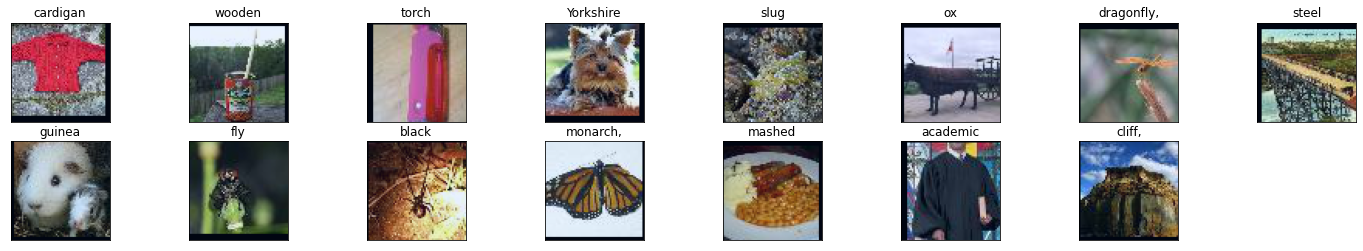

In [ ]:
batch_size = 32

trainTinyImageNet = Closed_TINYIMAGENET(set_name = 'train')
trainTinyImageNetLoader = torch.utils.data.DataLoader(trainTinyImageNet, batch_size = 32, shuffle = True)
print("Length of trainTinyImageNet is {}".format(len(trainTinyImageNet)))

testTinyImageNet = Closed_TINYIMAGENET(set_name = 'test')
testTinyImageNetLoader = torch.utils.data.DataLoader(testTinyImageNet, batch_size = 32, shuffle = True)
print("Length of testTinyImageNet is {}".format(len(testTinyImageNet)))

# Plot train images
train_dataiter = iter(trainTinyImageNetLoader)
images, targets = next(train_dataiter)
assert max(targets) < 180
images = images.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(trainTinyImageNet.mapping_name2english_name[trainTinyImageNet.mapping_id2name[targets[idx].item()]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
50000
Files already downloaded and verified
Files already downloaded and verified
50000
50000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


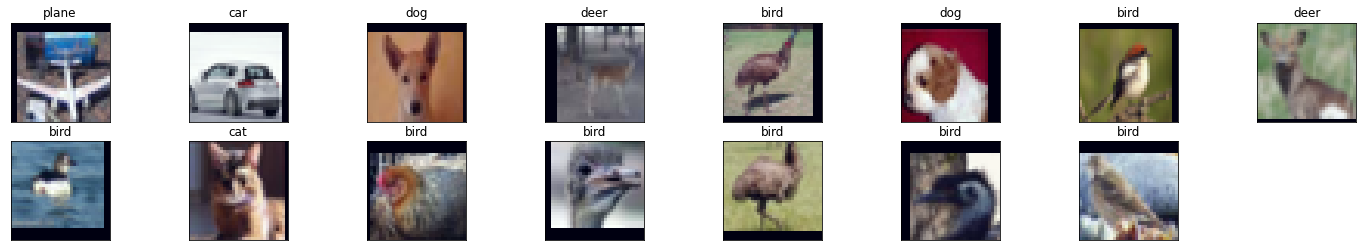

In [ ]:
trainset = CIFAR10(root='./data', train=True, download=True)
testset = CIFAR10(root='./data', train=False, download=True)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

print(len(trainset.targets))
print(len(trainset.data))

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

# im -= im.min() then im /= im.max()

train_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding = 4),                  
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])


trainset = CIFAR10(root='./data', train=True, download=True)
testset = CIFAR10(root='./data', train=False, download=True)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

print(len(trainset.targets))
print(len(trainset.data))

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

# im -= im.min() then im /= im.max()

train_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding = 4),                  
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])

class SplitCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, mode, transformFunc, iaa_compat = False):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()
        self.iaa_compat = iaa_compat

        if mode == "train": 
          for v in img2targets:
            _, target = v
            if target < split: 
              self.data.append(v)
        elif mode == "test": 
          for v in img2targets: 
            _, target = v 
            if target >= split: 
              self.data.append(v)
        else: 
          raise ValueError("Not a mode")
        
        self.transformFunc = transformFunc

        if self.iaa_compat: 
          self.contents = ["UNSEEN"] * (len(self.data) // 2)
          left = len(self.data) - len(self.contents)
          self.contents.extend((["SEEN"] * left))

          assert len(self.contents) == len(self.data)

          self.normal_transform = transforms.Compose([
                                                      transforms.ToPILImage(), 
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize(mean, std)])                             
    def __getitem__(self, i):
       img, target = self.data[i]
       if self.iaa_compat: 
         if self.contents[i] == "UNSEEN":
           img = self.transformFunc(image = img)
           target = torch.tensor(0, dtype = int)
         else: 
           '''SEEN data'''
           target = torch.tensor(1, dtype = int)

         img = self.normal_transform(img)
         return img, target 
       else: 
         img = self.transformFunc(img)
         return img, target

    def __len__(self):
        return len(self.data)

batch_size = 32

split = 6
train_closedset = SplitCIFAR(trainset.data, trainset.targets, split, "train", train_transform)
test_closedset = SplitCIFAR(testset.data, testset.targets, split, "train", test_transform)

test_openset = SplitCIFAR(testset.data, testset.targets, split, "test", test_transform)

train_closedloader = torch.utils.data.DataLoader(train_closedset, batch_size, shuffle = True)
test_closedloader = torch.utils.data.DataLoader(test_closedset, batch_size, shuffle = True)

test_openloader = torch.utils.data.DataLoader(test_openset, batch_size, shuffle = False)

# Plot train images
train_dataiter = iter(train_closedloader)
images, targets = next(train_dataiter)
images = images.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(list(classDict.keys())[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Low Level Noise Dataset

Len of NoiseLoader: 200
Len of UniformLoader: 200
Max 1.0
Min 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


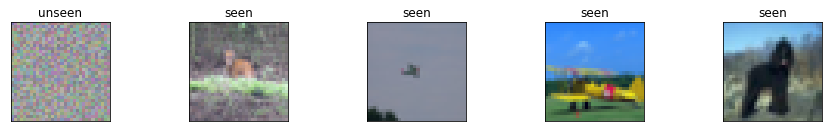

In [ ]:
mixed_classes = ["unseen", "seen"]
class PureNoiseData(torch.utils.data.Dataset): 
  
  def __init__(self, img_dim, noise_type, current_len, imgs, targets, split, transformFunc): 
    self.img_dim = img_dim
    assert type(self.img_dim) == tuple
    self.current_len = current_len
    indices = []
    for i, target in enumerate(targets): 
      if target < split: 
        indices.append(i)
    
    indices = indices[:current_len]
    self.imgs= list()
    self.datatypes = list()
    for ii in indices: 
      self.imgs.append(imgs[ii])
      self.datatypes.append("CIFAR")
    
    self.datatypes.extend(["NOISE"] * 100)

    self.noise_type = noise_type
    self.transformFunc = transformFunc

  def __getitem__(self, idx): 

    # adjust mu and sigma accordingly (that's why I created 2 variables)
    datatype = self.datatypes[idx]
    if datatype == "NOISE": 
      if self.noise_type == "normal": 
        mu, sigma = 0, 1
        return torch.from_numpy(np.random.normal(mu, sigma, size = self.img_dim)), 0
      elif self.noise_type == "uniform": 
        mu, sigma = 0, 1
        return torch.from_numpy(np.random.uniform(mu, sigma, size = self.img_dim)), 0
    elif datatype == "CIFAR": 
      img = self.imgs[idx]
      img = self.transformFunc(img)
      return img, 1
    else: 
      raise ValueError("Internal Error- Refactor Code")
  
  def __len__(self): 

    return self.current_len * 2


batch_size = 32

normalDisData = PureNoiseData((3, 32, 32), "normal", 100, testset.data, testset.targets, split, test_transform)
normalDisLoader = torch.utils.data.DataLoader(normalDisData, batch_size = batch_size, shuffle = True)
print("Len of NoiseLoader: {}".format(len(normalDisData)))

uniformDisData = PureNoiseData((3, 32, 32), "uniform", 100, testset.data, testset.targets, split, test_transform)
print("Len of UniformLoader: {}".format(len(uniformDisData)))
uniformDisLoader = torch.utils.data.DataLoader(uniformDisData, batch_size = batch_size, shuffle = True)

noiseIter = iter(uniformDisLoader)
imgs, targets = next(noiseIter)
imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

print("Max {}".format(imgs.max()))
print("Min {}".format(imgs.min()))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Closed set (6 known classes) under heavy augmentations:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


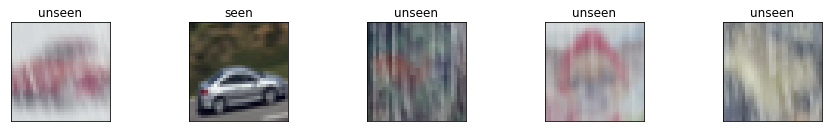

In [ ]:
transforms_noisyOE = iaa.Sequential([
   iaa.Fliplr(0.5),
   iaa.pillike.EnhanceContrast(),
   iaa.GaussianBlur(sigma=(0.1, 2)),
   iaa.Rain(speed=(0.5, 0.9))
])

# transforms_noisyOE = iaa.Sequential([
#    iaa.pillike.EnhanceContrast(),
#    iaa.GaussianBlur(sigma=(0.1, 1))
# ])



# transforms_noisyOE = transforms.Compose([
#    transforms.ToPILImage(), 
#    transforms.ColorJitter(contrast = 0.3),
#    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5)), 
#    transforms.ToTensor(),
#   transforms.Normalize((mean), (std))
# ])

split = 10

closed_set_heavy_Transforms = SplitCIFAR(testset.data, testset.targets, split, "train", transforms_noisyOE, iaa_compat = True)
closed_set_heavy_TransformsLoader = torch.utils.data.DataLoader(closed_set_heavy_Transforms, batch_size = batch_size, shuffle = True)

noiseRegIter = iter(closed_set_heavy_TransformsLoader)
imgs, targets = next(noiseRegIter)
imgs = imgs.float()
imgs -= imgs.min()
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Mixed Dataset of open and closed datasets with labels of whether they are open or closed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


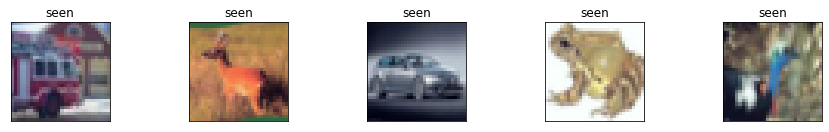

In [ ]:
from torch.utils.data.dataset import TensorDataset
class MixedCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, transformFunc):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()

        
        for v in img2targets:
          image, target = v
          if target < split: 
            self.data.append((image, 1))
          else: 
            self.data.append((image, 0))
        
        self.transformFunc = transformFunc

    def __getitem__(self, i):

       img, target = self.data[i]
       img = self.transformFunc(img)
       return img, target

    def __len__(self):
        return len(self.data)

train_mixedCIFAR = MixedCIFAR(trainset.data, trainset.targets, split, transformFunc = train_transform)
train_mixedCIFARLoader = torch.utils.data.DataLoader(train_mixedCIFAR, batch_size = batch_size, shuffle = True)

test_mixedCIFAR = MixedCIFAR(testset.data, testset.targets, split, transformFunc = test_transform)
test_mixedCIFARLoader = torch.utils.data.DataLoader(test_mixedCIFAR, batch_size = batch_size, shuffle = True)

mixed_classes = ["unseen", "seen"]
mixedCIFARiter = iter(test_mixedCIFARLoader)
imgs, targets = next(mixedCIFARiter)

images = imgs.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Outlier Exposure Datasets

In [ ]:
# Load Outlier Exposure datasets
# Train Datasets
mnist_OEtrainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
svhn_OEtrainset = torchvision.datasets.SVHN(root = './data', split = "train", download = True)

# Test Datasets
mnist_OEtestset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
svhn_OEtestset = torchvision.datasets.SVHN(root = './data', split = "test", download = True)

Len of CIFAR: 10000
Len of Entire Dataset 20000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


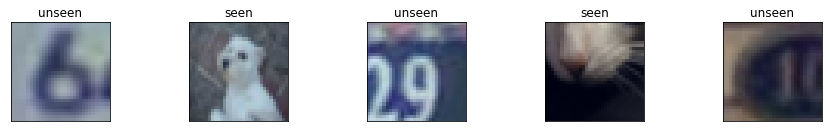

In [ ]:
class NewDataset_and_CIFAR(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, CIFAR_dataset, New_dataset_images, New_dataset_targets, split, transformFunc, OpenSetRec = False, MNIST = False):
    '''For CIFAR Only'''
    images, targets = CIFAR_dataset.data, CIFAR_dataset.targets
    img2targets = list(zip(images, targets))
    self.data = list()

    # if OpenSetRec: 
    #   self.data = img2targets
  
    for v in img2targets:
      img, target = v
      if target < split: 
        if OpenSetRec: 
          self.data.append((img, torch.tensor([1, int(target)])))
        else: 
          self.data.append((img, 1)) # 1 is seen
    
    print("Len of CIFAR: {}".format(len(self.data)))
    

    '''For New Dataset Only'''
    img2targets = list(zip(New_dataset_images, New_dataset_targets))[:(len(self.data))]

    for v in img2targets: 
      if not OpenSetRec: 
        self.data.append((v[0], 0)) # 0 is unseen
      else: 
        self.data.append((v[0], torch.tensor([0, 0])))
      
    
    self.transformFunc = transformFunc
    self.MNIST = MNIST
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    if type(img) != np.ndarray and self.MNIST: 
      # MNIST
      img = img.to(float)

      channel_1 = img.unsqueeze(0)
      channel_2 = channel_1.clone()
      channel_3 = channel_1.clone()
      
      img = torch.cat((channel_1, channel_2, channel_3), dim = 0)
      
      img = transforms.Resize(32)(img) 
      
    img = self.transformFunc(img)
    return img, target
    # img, target = self.data[i]
    # img = self.transformFunc(img)
    # return img, target


  def __len__(self):
    return len(self.data)

newDatasetAndCIFAR = NewDataset_and_CIFAR(testset, torch.from_numpy(svhn_OEtestset.data), torch.from_numpy(svhn_OEtestset.labels), split, test_transform)
newDatasetAndCIFARLoader = torch.utils.data.DataLoader(newDatasetAndCIFAR, batch_size = batch_size, shuffle = True)

mixed_classes = ["unseen", "seen"]
newDatasetAndCIFARiter = iter(newDatasetAndCIFARLoader)
imgs, targets = next(newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Len of CIFAR: 10000
Len of Entire Dataset 20000


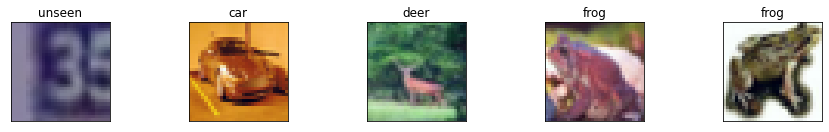

In [ ]:
'''Open Set Recognition Visualization and Loaders Defined'''

OSR_newDatasetAndCIFAR = NewDataset_and_CIFAR(testset, torch.from_numpy(svhn_OEtestset.data), torch.from_numpy(svhn_OEtestset.labels), split, test_transform, OpenSetRec = True)
OSR_newDatasetAndCIFARLoader = torch.utils.data.DataLoader(OSR_newDatasetAndCIFAR, batch_size = batch_size, shuffle = True)

OSR_newDatasetAndCIFARiter = iter(OSR_newDatasetAndCIFARLoader)
imgs, targets = next(OSR_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 1:'''
  if targets[idx][0] == 0: 
    ax.set_title(mixed_classes[targets[idx][-1]]) # Unseen
  else:
    ax.set_title(list(classDict.keys())[targets[idx][-1]])

# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
#               'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Len of CIFAR: 6000
Len of Entire Dataset 12000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


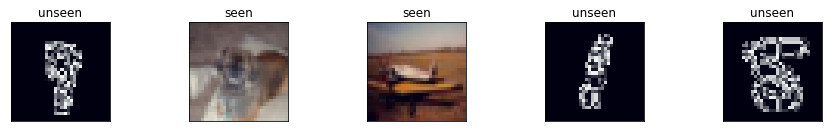

In [ ]:
MNISTAndCIFAR = NewDataset_and_CIFAR(testset, mnist_OEtestset.data, mnist_OEtestset.targets, 6, test_transform, MNIST = True)
MNISTAndCIFARLoader = torch.utils.data.DataLoader(MNISTAndCIFAR, batch_size = 32, shuffle = True)

mixed_classes = ["unseen", "seen"]
MNISTAndCIFARiter = iter(MNISTAndCIFARLoader)
imgs, targets = next(MNISTAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

#  Metrics: F_measure, ROC, PR (ROC and PR only work for binary validation)

In [ ]:
# Metrics: 

def F_measure(preds, labels, openset=False, theta=None):
  if openset:
      # f1 score for openset evaluation
      true_pos = 0.
      false_pos = 0.
      false_neg = 0.        
      for i in range(len(labels)):
          true_pos += 1 if preds[i] == labels[i] and labels[i] != -1 else 0
          false_pos += 1 if preds[i] != labels[i] and labels[i] != -1 else 0
          false_neg += 1 if preds[i] != labels[i] and labels[i] == -1 else 0

      precision = true_pos / (true_pos + false_pos)
      recall = true_pos / (true_pos + false_neg)
      return 2 * ((precision * recall) / (precision + recall + 1e-12))
  else: # Regular f1 score        
      return f1_score(labels, preds, average='macro')

def roc(scores, labels, **kwargs):
    """Returns the ROC curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)
    roc_data = {
        'tp': list(tpr),
        'fp': list(fpr),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return roc_data


def pr(scores, labels, **kwargs):
    """Returns the PR curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    auc_score = auc(recall, precision)

    pr_data = {
        'precision': list(precision),
        'recall': list(recall),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return pr_data

def ccr(scores, labels, **kwargs):
    """Returns the CCR VS FPR curve and returns the area under it.

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    max_indices = np.argmax(scores, axis=1) # Nx(K+1)
    max_values = np.take_along_axis(scores, max_indices[:, None], axis=1)
    data = list(zip([elem[0] for elem in max_values], max_indices, labels))
    data.sort(key=lambda x: x[0], reverse=True)
    cls_count = len(scores[0])
    unknown_count = len(np.where(labels == 0)[0])  # Unknown class is 0
    known_count = len(labels) - unknown_count
    fp = [0]
    tp = [0]
    thresholds = list()
    n = 0
    n_above_unknown = 0
    curr_unknown_prob = 1
    for score, pred_cls, gt_cls in data:
        if gt_cls == 0:
            curr_unknown_prob = score
            thresholds.append(score)
            fp.append(fp[-1] + 1)
            tp.append(n)
        elif pred_cls == gt_cls:
            n_above_unknown += 1
            if score < curr_unknown_prob:
                n = n_above_unknown
    fpr = np.asarray(fp[1:]) / unknown_count
    ccr = np.asarray(tp[1:]) / known_count
    auc_score = auc(fpr, ccr)
    ccr_data = {
        'ccr': list(ccr),
        'fpr': list(fpr),
        'thresh': thresholds,
        'auc': auc_score,
    }
    return ccr_data
    

# Build and Train K Way Classification Model 

In [ ]:
# Define resnet Model
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, split)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
epochs = 50
def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))
    
# Add validation on 4 other classes. 


def train(net, epochs, folder_weights):

  if os.path.exists(folder_weights): 
    raise RuntimeError("Folder already exists")

  os.mkdir(folder_weights)

  top_paths = dict()

  lr = 0.1 # lower learning rate: 0.003
  net = net.cuda()
  optimizer = torch.optim.SGD(
  net.parameters(), lr, momentum=0.9, 
  weight_decay=0.0005, nesterov=True)

  scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        epochs * len(train_closedloader),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / lr))
  
  model_path = ""
  for e in range(epochs): 
    correct = 0
    num_of_data = 0
    total_f_measure = 0
    model_path = os.path.join(folder_weights, "model_epoch{}.pth".format(e))
    net.train()  # enter train mode
    loss_avg = 0.0
    for data, target in tqdm(train_closedloader):
        data, target = data.cuda(), target.cuda()

        # forward
        x = net(data)

        # backward
        scheduler.step()
        optimizer.zero_grad()
        loss = F.cross_entropy(x, target)
        loss.backward()
        optimizer.step()

        # exponential moving average
        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

    stacked_pred = list()
    stacked_target = list()
    for data, target in tqdm(test_closedloader): 
      
      net.eval()
      num_of_data += data.size(0)
      data, target = data.cuda(), target.cuda()

      #forward
      x = net(data)
      prob = F.softmax(x, dim=1)
      assert sum(prob[0]).item() > 0.99 and sum(prob[0]).item() < 1.001

      pred = torch.argmax(prob, dim = 1)

      stacked_pred.extend(pred.tolist())
      stacked_target.extend(target.tolist())
      correct += torch.sum(pred == target)

    f_measure = F_measure(stacked_pred, stacked_target) * 100
    accuracy = (correct / num_of_data) * 100

    top_paths[model_path] = "{} f_measure, {} accuracy".format(f_measure, accuracy)
    
    print("Epoch: {}".format(e))
    print("Loss Avg: {}".format(loss_avg))
    print("Last Learning Rate: {}".format(scheduler.get_last_lr()))
    print("Accuracy: {}%".format(accuracy))
    print("F measure: {}%".format(f_measure))

    if (e % 5 == 0) and (e != 0): 
      torch.save(net.state_dict(), model_path)
      print("Model saved...")
    
  with open("model_weightsLOGS.txt", 'a+') as f:
    for k in top_paths.keys():
      final_string = '{} : {}'.format(k, top_paths[k]) 
      print(final_string, file=f)

  return net

In [ ]:
final_model = train(resnet50, epochs, "50th_epoch_train")

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 188/188 [00:03<00:00, 59.47it/s]


Epoch: 0
Loss Avg: 1.6545715218566723
Last Learning Rate: [0.09990133740804936]
Accuracy: 33.79999923706055%
F measure: 29.25832004816297%


100%|██████████| 188/188 [00:03<00:00, 60.51it/s]


Epoch: 1
Loss Avg: 1.4027557529403878
Last Learning Rate: [0.09960573900837325]
Accuracy: 42.03333282470703%
F measure: 34.03186869543354%


100%|██████████| 188/188 [00:03<00:00, 60.59it/s]


Epoch: 2
Loss Avg: 1.3214758172721568
Last Learning Rate: [0.09911437139280908]
Accuracy: 48.36666488647461%
F measure: 46.95301026782534%


100%|██████████| 188/188 [00:03<00:00, 59.94it/s]


Epoch: 3
Loss Avg: 1.2883121432184166
Last Learning Rate: [0.098429173764851]
Accuracy: 52.64999771118164%
F measure: 52.343113106105186%


100%|██████████| 188/188 [00:03<00:00, 61.15it/s]


Epoch: 4
Loss Avg: 1.3650398539724429
Last Learning Rate: [0.09755285028649954]
Accuracy: 52.499996185302734%
F measure: 52.208675484507395%


100%|██████████| 188/188 [00:03<00:00, 61.96it/s]


Epoch: 5
Loss Avg: 1.1219489584880882
Last Learning Rate: [0.09648885940616964]
Accuracy: 54.39999771118164%
F measure: 53.13614214537695%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.52it/s]


Epoch: 6
Loss Avg: 1.0711876074338587
Last Learning Rate: [0.09524140020977474]
Accuracy: 53.48332977294922%
F measure: 48.45493431597376%


100%|██████████| 188/188 [00:03<00:00, 60.79it/s]


Epoch: 7
Loss Avg: 1.1857342469519332
Last Learning Rate: [0.09381539584885316]
Accuracy: 48.916664123535156%
F measure: 48.68494910790464%


100%|██████████| 188/188 [00:03<00:00, 61.19it/s]


Epoch: 8
Loss Avg: 1.1526642974923698
Last Learning Rate: [0.09221647411113801]
Accuracy: 56.75%
F measure: 56.06953226017916%


100%|██████████| 188/188 [00:03<00:00, 60.39it/s]


Epoch: 9
Loss Avg: 1.0571161777325002
Last Learning Rate: [0.0904509452102502]
Accuracy: 62.900001525878906%
F measure: 62.703949205837404%


100%|██████████| 188/188 [00:03<00:00, 61.17it/s]


Epoch: 10
Loss Avg: 1.0039649113821232
Last Learning Rate: [0.08852577688216808]
Accuracy: 60.04999923706055%
F measure: 60.80037787352438%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.87it/s]


Epoch: 11
Loss Avg: 1.0529138934224473
Last Learning Rate: [0.08644856688675687]
Accuracy: 61.099998474121094%
F measure: 61.231627671310854%


100%|██████████| 188/188 [00:03<00:00, 61.03it/s]


Epoch: 12
Loss Avg: 1.1047535348471462
Last Learning Rate: [0.08422751302288148]
Accuracy: 65.93333435058594%
F measure: 64.44536108055608%


100%|██████████| 188/188 [00:03<00:00, 60.69it/s]


Epoch: 13
Loss Avg: 0.9723956674678765
Last Learning Rate: [0.08187138077543962]
Accuracy: 61.983333587646484%
F measure: 61.60168960511806%


100%|██████████| 188/188 [00:03<00:00, 60.85it/s]


Epoch: 14
Loss Avg: 1.0204833063893637
Last Learning Rate: [0.07938946872199752]
Accuracy: 61.14999771118164%
F measure: 59.74548069166005%


100%|██████████| 188/188 [00:03<00:00, 60.71it/s]


Epoch: 15
Loss Avg: 0.9515330707066165
Last Learning Rate: [0.07679157183555235]
Accuracy: 62.133331298828125%
F measure: 60.90696905274656%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.56it/s]


Epoch: 16
Loss Avg: 1.0611327181359336
Last Learning Rate: [0.07408794282824871]
Accuracy: 61.599998474121094%
F measure: 61.49288828879009%


100%|██████████| 188/188 [00:03<00:00, 60.95it/s]


Epoch: 17
Loss Avg: 0.957608411677541
Last Learning Rate: [0.07128925168860785]
Accuracy: 65.36666870117188%
F measure: 65.34938565359444%


100%|██████████| 188/188 [00:03<00:00, 60.76it/s]


Epoch: 18
Loss Avg: 0.8586375921837439
Last Learning Rate: [0.06840654357195756]
Accuracy: 67.88333129882812%
F measure: 68.01075028619734%


100%|██████████| 188/188 [00:03<00:00, 60.59it/s]


Epoch: 19
Loss Avg: 1.0595744858817429
Last Learning Rate: [0.06545119521025018]
Accuracy: 63.55000305175781%
F measure: 63.905892409153964%


100%|██████████| 188/188 [00:03<00:00, 58.92it/s]


Epoch: 20
Loss Avg: 0.8340292379048921
Last Learning Rate: [0.06243487001329917]
Accuracy: 62.4666633605957%
F measure: 61.605178191889905%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 59.65it/s]


Epoch: 21
Loss Avg: 0.8573392399871769
Last Learning Rate: [0.05936947203862895]
Accuracy: 67.03333282470703%
F measure: 66.38167616335359%


100%|██████████| 188/188 [00:03<00:00, 56.99it/s]


Epoch: 22
Loss Avg: 0.8088726527691411
Last Learning Rate: [0.05626709901159843]
Accuracy: 68.81666564941406%
F measure: 67.97017212633462%


100%|██████████| 188/188 [00:03<00:00, 57.77it/s]


Epoch: 23
Loss Avg: 0.9927590104591582
Last Learning Rate: [0.05313999458120591]
Accuracy: 67.79999542236328%
F measure: 67.59688117894936%


100%|██████████| 188/188 [00:03<00:00, 57.04it/s]


Epoch: 24
Loss Avg: 0.915356166459883
Last Learning Rate: [0.0500005]
Accuracy: 71.13333129882812%
F measure: 70.92668374296044%


100%|██████████| 188/188 [00:03<00:00, 60.39it/s]


Epoch: 25
Loss Avg: 0.8595999900706733
Last Learning Rate: [0.0468610054187941]
Accuracy: 72.21666717529297%
F measure: 71.54248318189683%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.17it/s]


Epoch: 26
Loss Avg: 0.7753382834508362
Last Learning Rate: [0.04373390098840157]
Accuracy: 70.20000457763672%
F measure: 70.6425371397268%


100%|██████████| 188/188 [00:03<00:00, 58.00it/s]


Epoch: 27
Loss Avg: 0.7007415618760459
Last Learning Rate: [0.04063152796137106]
Accuracy: 72.75%
F measure: 72.05590601908192%


100%|██████████| 188/188 [00:03<00:00, 58.20it/s]


Epoch: 28
Loss Avg: 0.7188449410159475
Last Learning Rate: [0.03756612998670086]
Accuracy: 72.18333435058594%
F measure: 71.83237870429116%


100%|██████████| 188/188 [00:03<00:00, 60.89it/s]


Epoch: 29
Loss Avg: 0.715145220427644
Last Learning Rate: [0.034549804789749824]
Accuracy: 72.98332977294922%
F measure: 72.90791885016908%


100%|██████████| 188/188 [00:03<00:00, 58.74it/s]


Epoch: 30
Loss Avg: 0.6973931300378655
Last Learning Rate: [0.03159445642804245]
Accuracy: 72.98332977294922%
F measure: 72.60587222145448%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 58.38it/s]


Epoch: 31
Loss Avg: 0.6607591873549912
Last Learning Rate: [0.028711748311392157]
Accuracy: 74.5999984741211%
F measure: 74.14417744821505%


100%|██████████| 188/188 [00:03<00:00, 58.38it/s]


Epoch: 32
Loss Avg: 0.6686497710754128
Last Learning Rate: [0.025913057171751283]
Accuracy: 73.81666564941406%
F measure: 73.21869827082597%


100%|██████████| 188/188 [00:03<00:00, 59.85it/s]


Epoch: 33
Loss Avg: 0.7239760575842764
Last Learning Rate: [0.02320942816444765]
Accuracy: 73.94999694824219%
F measure: 73.82975067363734%


100%|██████████| 188/188 [00:03<00:00, 60.12it/s]


Epoch: 34
Loss Avg: 0.53172804146747
Last Learning Rate: [0.0206115312780025]
Accuracy: 78.0999984741211%
F measure: 78.12049610020068%


100%|██████████| 188/188 [00:03<00:00, 57.97it/s]


Epoch: 35
Loss Avg: 0.624300035876924
Last Learning Rate: [0.01812961922456039]
Accuracy: 79.39999389648438%
F measure: 79.33709401739118%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 59.65it/s]


Epoch: 36
Loss Avg: 0.5514120456818544
Last Learning Rate: [0.01577348697711853]
Accuracy: 77.9000015258789%
F measure: 77.91125069506495%


100%|██████████| 188/188 [00:03<00:00, 59.80it/s]


Epoch: 37
Loss Avg: 0.5708361479144489
Last Learning Rate: [0.013552433113243147]
Accuracy: 78.91666412353516%
F measure: 78.5004853691148%


100%|██████████| 188/188 [00:03<00:00, 59.49it/s]


Epoch: 38
Loss Avg: 0.6363781904360476
Last Learning Rate: [0.011475223117831931]
Accuracy: 79.8499984741211%
F measure: 79.63773262463144%


100%|██████████| 188/188 [00:03<00:00, 60.89it/s]


Epoch: 39
Loss Avg: 0.47760797137781164
Last Learning Rate: [0.009550054789749822]
Accuracy: 80.51666259765625%
F measure: 80.55962377263991%


100%|██████████| 188/188 [00:03<00:00, 59.71it/s]


Epoch: 40
Loss Avg: 0.46092768689168373
Last Learning Rate: [0.007784525888862009]
Accuracy: 82.13333129882812%
F measure: 82.14114181716991%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.44it/s]


Epoch: 41
Loss Avg: 0.4951119767230955
Last Learning Rate: [0.0061856041511468545]
Accuracy: 82.25%
F measure: 82.07263634996524%


100%|██████████| 188/188 [00:03<00:00, 60.32it/s]


Epoch: 42
Loss Avg: 0.30824971354067854
Last Learning Rate: [0.004759599790225266]
Accuracy: 82.51666259765625%
F measure: 82.52474548858405%


100%|██████████| 188/188 [00:03<00:00, 59.66it/s]


Epoch: 43
Loss Avg: 0.39171502408251063
Last Learning Rate: [0.003512140593830377]
Accuracy: 83.5%
F measure: 83.30761788475904%


100%|██████████| 188/188 [00:03<00:00, 60.75it/s]


Epoch: 44
Loss Avg: 0.415290198610064
Last Learning Rate: [0.002448149713500471]
Accuracy: 84.36666870117188%
F measure: 84.30824966950556%


100%|██████████| 188/188 [00:03<00:00, 59.90it/s]


Epoch: 45
Loss Avg: 0.4119389411087145
Last Learning Rate: [0.0015718262351490106]
Accuracy: 84.6500015258789%
F measure: 84.55077080337247%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 60.99it/s]


Epoch: 46
Loss Avg: 0.41248247523130455
Last Learning Rate: [0.0008866286071909339]
Accuracy: 84.79999542236328%
F measure: 84.7487031638724%


100%|██████████| 188/188 [00:03<00:00, 59.91it/s]


Epoch: 47
Loss Avg: 0.3878476934874642
Last Learning Rate: [0.00039526099162676896]
Accuracy: 85.31666564941406%
F measure: 85.20422266354709%


100%|██████████| 188/188 [00:03<00:00, 60.51it/s]


Epoch: 48
Loss Avg: 0.2975351841436925
Last Learning Rate: [9.966259195063621e-05]
Accuracy: 85.36666870117188%
F measure: 85.28828738047851%


100%|██████████| 188/188 [00:03<00:00, 59.01it/s]

Epoch: 49
Loss Avg: 0.32777545037390915
Last Learning Rate: [1e-06]
Accuracy: 85.23332977294922%
F measure: 85.17276141659548%


In [ ]:
final_model = train(resnet50, epochs, "30th_epoch_train")

  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 188/188 [00:03<00:00, 55.86it/s]


Epoch: 0
Loss Avg: 1.787086377991531
Last Learning Rate: [0.09972609750746599]
Accuracy: 20.850000381469727%
F measure: 11.73445782798959%


100%|██████████| 188/188 [00:03<00:00, 56.14it/s]


Epoch: 1
Loss Avg: 1.637167743368493
Last Learning Rate: [0.09890739096288992]
Accuracy: 27.46666717529297%
F measure: 19.248286386632962%


100%|██████████| 188/188 [00:03<00:00, 55.21it/s]


Epoch: 2
Loss Avg: 1.460073635287952
Last Learning Rate: [0.09755285028649954]
Accuracy: 40.06666564941406%
F measure: 33.75485285074085%


100%|██████████| 188/188 [00:03<00:00, 56.01it/s]


Epoch: 3
Loss Avg: 1.4829671603160237
Last Learning Rate: [0.09567731610940122]
Accuracy: 45.5%
F measure: 40.00065402679602%


100%|██████████| 188/188 [00:03<00:00, 55.35it/s]


Epoch: 4
Loss Avg: 1.2634127166661315
Last Learning Rate: [0.09330133717652006]
Accuracy: 47.599998474121094%
F measure: 45.59182589210259%


100%|██████████| 188/188 [00:03<00:00, 56.43it/s]


Epoch: 5
Loss Avg: 1.305152191111484
Last Learning Rate: [0.0904509452102502]
Accuracy: 48.016666412353516%
F measure: 46.04343519750323%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 55.85it/s]


Epoch: 6
Loss Avg: 1.2175306124877663
Last Learning Rate: [0.08715736970145699]
Accuracy: 51.666664123535156%
F measure: 48.808158215892654%


100%|██████████| 188/188 [00:03<00:00, 57.25it/s]


Epoch: 7
Loss Avg: 1.1820861296980143
Last Learning Rate: [0.08345669575263974]
Accuracy: 48.71666717529297%
F measure: 46.83098114311996%


100%|██████████| 188/188 [00:03<00:00, 55.85it/s]


Epoch: 8
Loss Avg: 1.1480413525114206
Last Learning Rate: [0.07938946872199752]
Accuracy: 58.04999923706055%
F measure: 56.110626076030435%


100%|██████████| 188/188 [00:04<00:00, 43.72it/s]


Epoch: 9
Loss Avg: 1.1903286044652412
Last Learning Rate: [0.07500025]
Accuracy: 60.9666633605957%
F measure: 58.61337250385647%


100%|██████████| 188/188 [00:03<00:00, 56.48it/s]


Epoch: 10
Loss Avg: 1.1795089037615596
Last Learning Rate: [0.07033712878546848]
Accuracy: 62.33333206176758%
F measure: 60.9399224462687%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 56.72it/s]


Epoch: 11
Loss Avg: 1.0621712388751061
Last Learning Rate: [0.06545119521025018]
Accuracy: 63.19999694824219%
F measure: 61.84365947443183%


100%|██████████| 188/188 [00:03<00:00, 56.34it/s]


Epoch: 12
Loss Avg: 1.0431587087979908
Last Learning Rate: [0.06039598058504256]
Accuracy: 67.0999984741211%
F measure: 66.8315594998572%


100%|██████████| 188/188 [00:03<00:00, 55.73it/s]


Epoch: 13
Loss Avg: 0.8489678605509421
Last Learning Rate: [0.05522687089915104]
Accuracy: 67.33333587646484%
F measure: 66.86099868199568%


100%|██████████| 188/188 [00:03<00:00, 55.77it/s]


Epoch: 14
Loss Avg: 0.8574027785719661
Last Learning Rate: [0.0500005]
Accuracy: 68.0999984741211%
F measure: 67.67349125885609%


100%|██████████| 188/188 [00:03<00:00, 55.70it/s]


Epoch: 15
Loss Avg: 0.84320353053782
Last Learning Rate: [0.04477412910084897]
Accuracy: 65.63333129882812%
F measure: 65.07792581132699%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 55.95it/s]


Epoch: 16
Loss Avg: 0.799236351463424
Last Learning Rate: [0.039605019414957456]
Accuracy: 69.73333740234375%
F measure: 69.83009203550287%


100%|██████████| 188/188 [00:03<00:00, 56.53it/s]


Epoch: 17
Loss Avg: 0.7960139652124034
Last Learning Rate: [0.034549804789749824]
Accuracy: 72.73332977294922%
F measure: 72.508311590471%


100%|██████████| 188/188 [00:03<00:00, 51.95it/s]


Epoch: 18
Loss Avg: 0.6994517467443925
Last Learning Rate: [0.02966387121453154]
Accuracy: 73.88333129882812%
F measure: 73.42243570003049%


100%|██████████| 188/188 [00:03<00:00, 55.98it/s]


Epoch: 19
Loss Avg: 0.8573214993164147
Last Learning Rate: [0.025000750000000013]
Accuracy: 73.11666870117188%
F measure: 72.52721963711858%


100%|██████████| 188/188 [00:03<00:00, 56.03it/s]


Epoch: 20
Loss Avg: 0.6756489604973493
Last Learning Rate: [0.0206115312780025]
Accuracy: 76.63333129882812%
F measure: 76.44829318258061%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 56.44it/s]


Epoch: 21
Loss Avg: 0.6955026791127932
Last Learning Rate: [0.016544304247360288]
Accuracy: 75.33333587646484%
F measure: 75.30339820853827%


100%|██████████| 188/188 [00:03<00:00, 57.09it/s]


Epoch: 22
Loss Avg: 0.6452471347834595
Last Learning Rate: [0.012843630298543022]
Accuracy: 77.91666412353516%
F measure: 77.74841151375519%


100%|██████████| 188/188 [00:03<00:00, 56.41it/s]


Epoch: 23
Loss Avg: 0.631237770926385
Last Learning Rate: [0.009550054789749822]
Accuracy: 79.61666870117188%
F measure: 79.35751451181646%


100%|██████████| 188/188 [00:03<00:00, 55.83it/s]


Epoch: 24
Loss Avg: 0.49308879019460083
Last Learning Rate: [0.006699662823479957]
Accuracy: 79.73332977294922%
F measure: 79.56169284414896%


100%|██████████| 188/188 [00:03<00:00, 56.58it/s]


Epoch: 25
Loss Avg: 0.5614981354861331
Last Learning Rate: [0.004323683890598773]
Accuracy: 82.06666564941406%
F measure: 81.9271994393875%
Model saved...


100%|██████████| 188/188 [00:03<00:00, 57.07it/s]


Epoch: 26
Loss Avg: 0.505315468592301
Last Learning Rate: [0.002448149713500471]
Accuracy: 82.05000305175781%
F measure: 82.09073679338795%


100%|██████████| 188/188 [00:04<00:00, 46.54it/s]


Epoch: 27
Loss Avg: 0.41317352116834066
Last Learning Rate: [0.0010936090371100825]
Accuracy: 82.78333282470703%
F measure: 82.67641591512444%


100%|██████████| 188/188 [00:03<00:00, 56.17it/s]


Epoch: 28
Loss Avg: 0.3873661409716073
Last Learning Rate: [0.00027490249253401964]
Accuracy: 83.36666870117188%
F measure: 83.27496166793799%


100%|██████████| 188/188 [00:03<00:00, 56.55it/s]

Epoch: 29
Loss Avg: 0.34527114666484715
Last Learning Rate: [1e-06]
Accuracy: 83.58332824707031%
F measure: 83.46892992685171%


In [ ]:
torch.save(final_model.state_dict(), "epoch50thKway.pth")

# Build and Validate Max Softmax probability and Max Logits scores.

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, split)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

def evaluate_max_models(form, kway_model_path, data_loader): 

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  for data, target in tqdm(data_loader): 

    data, target = data.cuda(), target.cuda()
    num_of_data += data.size(0)

    #forward
    x = net(data.float())

    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())

  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))
  print(roc_measure, pr_measure)

  return roc_measure, pr_measure

Run Max Softmax Probabilities on test_mixedCIFARLoader

In [ ]:
max_softmaxprob_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", test_mixedCIFARLoader)

100%|██████████| 313/313 [00:06<00:00, 46.60it/s]




ROC AU value: 62.03239791666666%
PR AU value: 70.93395607848333%


Run Max Logits on test_mixedCIFARLoader

In [ ]:
max_logits_metrics = evaluate_max_models("logits", "/content/epoch30thKway.pth", test_mixedCIFARLoader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 313/313 [00:09<00:00, 31.37it/s]



ROC AU value: 70.90532083333333%
PR AU value: 77.61123706839246%
70.90532083333333 77.61123706839246


Run Max Softmax Probabilities on Uniform Noise DataLoader and Normal Noise DataLoader

In [ ]:
print("Uniform Distribution: ")
max_softmaxprob_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", uniformDisLoader)

print("\n")

print("Normal Distribution: ")
max_softmaxprob_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", normalDisLoader)

Uniform Distribution: 


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 7/7 [00:00<00:00, 51.32it/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: A



ROC AU value: 62.150000000000006%
PR AU value: 74.32607174353114%
62.150000000000006 74.32607174353114


Normal Distribution: 


100%|██████████| 7/7 [00:00<00:00, 52.06it/s]



ROC AU value: 90.54%
PR AU value: 92.71089461930033%
90.54 92.71089461930033


Run Max Logits on Uniform Noise DataLoader

In [ ]:
print("Uniform Distribution: ")
max_logit_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", uniformDisLoader)

print("\n")

print("Normal Distribution: ")
max_logits_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", normalDisLoader)

Uniform Distribution: 


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 7/7 [00:00<00:00, 49.69it/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: A



ROC AU value: 71.16%
PR AU value: 81.79172781163166%
71.16 81.79172781163166


Normal Distribution: 


100%|██████████| 7/7 [00:00<00:00, 48.71it/s]



ROC AU value: 80.89999999999999%
PR AU value: 85.75189871794264%
80.89999999999999 85.75189871794264


Run Max Softmax on Heavy Transforms (Flipping, Gaussian Blurring, Raining Affect) on closed_set images

In [ ]:
max_softmaxprob_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", closed_set_heavy_TransformsLoader)

100%|██████████| 188/188 [00:23<00:00,  8.15it/s]



ROC AU value: 68.26209444444444%
PR AU value: 71.7399916181242%


Run Max Logits on Heavy Transforms (Flipping, Gaussian Blurring, Raining Affect) on closed_set images

In [ ]:
max_logit_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", closed_set_heavy_TransformsLoader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 313/313 [00:42<00:00,  7.34it/s]



ROC AU value: 65.478736%
PR AU value: 69.45880602991421%
65.478736 69.45880602991421


Run Max Softmax on SVHN + CIFAR Dataset

In [ ]:
max_softmaxprob_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", newDatasetAndCIFARLoader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 625/625 [00:12<00:00, 49.85it/s]



ROC AU value: 76.389837%
PR AU value: 81.73958968088347%
76.389837 81.73958968088347


Run Max Logits on SVHN + CIFAR Dataset

In [ ]:
max_logit_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", newDatasetAndCIFARLoader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 625/625 [00:10<00:00, 60.09it/s]



ROC AU value: 67.0716255%
PR AU value: 74.907815703786%
67.0716255 74.907815703786


Run Max Logits on MNIST + CIFAR Dataset

In [ ]:
max_logit_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", MNISTAndCIFARLoader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 375/375 [00:07<00:00, 47.14it/s]



ROC AU value: 93.4136625%
PR AU value: 94.42958965144553%
93.4136625 94.42958965144553


# Build and Train Binary Classifier
# Requirements: Trained K Way classification backbone

In [ ]:
def build_binary_classifier(model_path): 
  bn_classifier = torchvision.models.resnet50(pretrained = False)
  model_state_dict = torch.load(model_path)

  del model_state_dict['fc.weight']
  del model_state_dict['fc.bias']
  bn_classifier.load_state_dict(model_state_dict, strict = False)

  for param in bn_classifier.parameters(): 
    bn_classifier.requires_grad = False

  bn_classifier.fc = nn.Sequential(
      nn.Linear(bn_classifier.fc.in_features, 512), 
      nn.ReLU(inplace = True),
      nn.Dropout(), 
      nn.Linear(512, 128), 
      nn.ReLU(inplace = True), 
      nn.Dropout(), 
      nn.Linear(128, 32), 
      nn.ReLU(inplace = True), 
      nn.Dropout(),
      nn.Linear(32, 1)
  )

  # bn_classifier.fc = nn.Linear(bn_classifier.fc.in_features, 1, bias = True)

  return bn_classifier

bn_net = build_binary_classifier("/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth")

In [ ]:
epochs = 20
def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))
    
def train_bn_classifier(net, epochs, folder_weights):

  if os.path.exists(folder_weights): 
    raise RuntimeError("Folder already exists")

  os.mkdir(folder_weights)

  top_paths = {}
  best_model = {}

  lr = 0.01
  net = net.cuda()
  bn_optimizer = torch.optim.SGD(
  net.fc.parameters(), lr, momentum=0.9, 
  weight_decay=0.0005, nesterov=True)

  scheduler = torch.optim.lr_scheduler.LambdaLR(
    bn_optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        epochs * len(train_mixedCIFARLoader),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / lr))
  
  model_path = ""
  for e in range(epochs): 
    correct = 0
    num_of_data = 0
    model_path = os.path.join(folder_weights, "bn_model_epoch{}.pth".format(e))
    net.train()  # enter train mode
    loss_avg = 0.0
    for data, target in tqdm(train_mixedCIFARLoader):
      target = target.unsqueeze(1)
      data, target = data.cuda(), target.cuda()
      
      # forward
      x = net(data)

      # backward
      scheduler.step()
      bn_optimizer.zero_grad()
      loss = nn.BCEWithLogitsLoss()(x, target.float())
      loss.backward()
      bn_optimizer.step()

      # exponential moving average
      loss_avg = loss_avg * 0.8 + float(loss) * 0.2
    
    stacked_pred = list()
    stacked_target = list()
    stacked_outs = list()
    # stacked_confidence

    for data, target in tqdm(test_mixedCIFARLoader): 
      data, target = data.cuda(), target.cuda()
      net.eval()
      num_of_data += data.size(0)

      #forward
      x = net(data)
      x = torch.sigmoid(x)
      x = x.squeeze(-1)

      pred = torch.round(x)

      stacked_outs.extend(x.tolist())
      stacked_pred.extend(pred.tolist()) # Only 0's and 1's
      stacked_target.extend(target.tolist())
      correct += torch.sum(pred == target)

    f_measure = F_measure(stacked_pred, stacked_target) * 100

    roc_measure = roc(stacked_outs, stacked_target)['auc'] * 100
    pr_measure = pr(stacked_outs, stacked_target)['auc'] * 100

    accuracy = (correct / num_of_data) * 100

    top_paths[model_path] = "{} f_measure, {} roc_measure, {} pr_measure, {} accuracy".format(f_measure, roc_measure, pr_measure, accuracy)
    print(model_path)
    best_model[model_path] = roc_measure
    sorted_best_model = sorted(best_model, key = best_model.get, reverse = True)
    '''Clean all the lower roc models'''
    saved_paths = glob.glob(os.path.join(folder_weights, "*.pth"))
    for pth in saved_paths: 
      if pth not in sorted_best_model[:3]: 
        os.remove(pth)

    for m_pf in sorted_best_model[:3]: 
      if not os.path.isfile(m_pf): 
        torch.save(net.state_dict(), model_path)
    
    assert len(glob.glob(os.path.join(folder_weights, "*.pth"))) <= 3
    print("Best Model saved or kept...")

    print("Epoch: {}".format(e))
    print("Loss Avg: {}".format(loss_avg))
    print("Last Learning Rate: {}".format(scheduler.get_last_lr()))
    print("Accuracy: {}%".format(accuracy))
    print("F measure: {}%".format(f_measure))
    print("ROC measure: {}%".format(roc_measure))
    print("PR measure: {}%".format(pr_measure))

    if (e % 5 == 0) and (e != 0): 
      torch.save(net.state_dict(), model_path)
      print("Model saved...")
    
  with open("bn_model_weightsLOGS.txt", 'a+') as f:
    for k in top_paths.keys():
      final_string = '{} : {}'.format(k, top_paths[k]) 
      print(final_string, file=f)

  return net

In [ ]:
bn_net = train_bn_classifier(bn_net, 40, "REALfinal_train")

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 313/313 [00:06<00:00, 48.31it/s]


REALfinal_train/bn_model_epoch0.pth
Best Model saved or kept...
Epoch: 0
Loss Avg: 0.5589472174126431
Last Learning Rate: [0.009984588209998774]
Accuracy: 70.61000061035156%
F measure: 66.88225876742618%
ROC measure: 78.0862625%
PR measure: 84.5500395837584%


100%|██████████| 313/313 [00:06<00:00, 47.79it/s]


REALfinal_train/bn_model_epoch1.pth
Best Model saved or kept...
Epoch: 1
Loss Avg: 0.5255356499596877
Last Learning Rate: [0.009938447858805391]
Accuracy: 70.44999694824219%
F measure: 66.17521524667912%
ROC measure: 78.49220416666667%
PR measure: 84.92070127371741%


100%|██████████| 313/313 [00:06<00:00, 47.68it/s]


REALfinal_train/bn_model_epoch2.pth
Best Model saved or kept...
Epoch: 2
Loss Avg: 0.5813866549129371
Last Learning Rate: [0.009861863417028185]
Accuracy: 72.5199966430664%
F measure: 70.36952821258686%
ROC measure: 79.91728333333333%
PR measure: 85.99227204377989%


100%|██████████| 313/313 [00:06<00:00, 48.17it/s]


REALfinal_train/bn_model_epoch3.pth
Best Model saved or kept...
Epoch: 3
Loss Avg: 0.5735542616449145
Last Learning Rate: [0.00975530705321762]
Accuracy: 72.20999908447266%
F measure: 69.10761321251042%
ROC measure: 80.00135208333334%
PR measure: 86.11595263046937%


100%|██████████| 313/313 [00:06<00:00, 48.46it/s]


REALfinal_train/bn_model_epoch4.pth
Best Model saved or kept...
Epoch: 4
Loss Avg: 0.5836703043027476
Last Learning Rate: [0.00961943572279018]
Accuracy: 72.65999603271484%
F measure: 70.75538477441897%
ROC measure: 79.92735208333332%
PR measure: 85.98262181303072%


100%|██████████| 313/313 [00:06<00:00, 47.77it/s]


REALfinal_train/bn_model_epoch5.pth
Best Model saved or kept...
Epoch: 5
Loss Avg: 0.5654865393349119
Last Learning Rate: [0.009455087117679745]
Accuracy: 72.47000122070312%
F measure: 70.06028106294507%
ROC measure: 80.38535833333333%
PR measure: 86.40854958773215%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 47.64it/s]


REALfinal_train/bn_model_epoch6.pth
Best Model saved or kept...
Epoch: 6
Loss Avg: 0.5977926716815961
Last Learning Rate: [0.009263274501688283]
Accuracy: 71.86000061035156%
F measure: 68.26918340980303%
ROC measure: 80.35528749999999%
PR measure: 86.33155883492203%


100%|██████████| 313/313 [00:06<00:00, 47.94it/s]


REALfinal_train/bn_model_epoch7.pth
Best Model saved or kept...
Epoch: 7
Loss Avg: 0.5457717904241002
Last Learning Rate: [0.00904518046337755]
Accuracy: 72.77999877929688%
F measure: 70.93107572234783%
ROC measure: 80.27519583333333%
PR measure: 86.1802544210888%


100%|██████████| 313/313 [00:06<00:00, 48.03it/s]


REALfinal_train/bn_model_epoch8.pth
Best Model saved or kept...
Epoch: 8
Loss Avg: 0.5505952238537475
Last Learning Rate: [0.008802149625017354]
Accuracy: 72.29000091552734%
F measure: 69.40867633749191%
ROC measure: 80.30020833333333%
PR measure: 86.30697358987806%


100%|██████████| 313/313 [00:06<00:00, 49.26it/s]


REALfinal_train/bn_model_epoch9.pth
Best Model saved or kept...
Epoch: 9
Loss Avg: 0.6154941993142427
Last Learning Rate: [0.008535680352542145]
Accuracy: 72.7699966430664%
F measure: 70.70833264891088%
ROC measure: 80.13250208333334%
PR measure: 86.06992261512136%


100%|██████████| 313/313 [00:06<00:00, 48.72it/s]


REALfinal_train/bn_model_epoch10.pth
Best Model saved or kept...
Epoch: 10
Loss Avg: 0.564838684864834
Last Learning Rate: [0.008247415517626751]
Accuracy: 72.72999572753906%
F measure: 70.11320781516272%
ROC measure: 80.42938958333335%
PR measure: 86.38071481816239%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 48.46it/s]


REALfinal_train/bn_model_epoch11.pth
Best Model saved or kept...
Epoch: 11
Loss Avg: 0.5396465893138331
Last Learning Rate: [0.00793913236883622]
Accuracy: 73.04999542236328%
F measure: 71.15202694475613%
ROC measure: 80.33548125%
PR measure: 86.22843422429499%


100%|██████████| 313/313 [00:06<00:00, 48.25it/s]


REALfinal_train/bn_model_epoch12.pth
Best Model saved or kept...
Epoch: 12
Loss Avg: 0.5082427690435545
Last Learning Rate: [0.007612731574297386]
Accuracy: 73.18999481201172%
F measure: 71.4824218914332%
ROC measure: 80.66341249999999%
PR measure: 86.62300842447749%


100%|██████████| 313/313 [00:06<00:00, 48.42it/s]


REALfinal_train/bn_model_epoch13.pth
Best Model saved or kept...
Epoch: 13
Loss Avg: 0.5458182303142267
Last Learning Rate: [0.007270225503447864]
Accuracy: 73.2699966430664%
F measure: 71.2560218392294%
ROC measure: 80.26667291666666%
PR measure: 86.14258202048548%


100%|██████████| 313/313 [00:06<00:00, 48.88it/s]


REALfinal_train/bn_model_epoch14.pth
Best Model saved or kept...
Epoch: 14
Loss Avg: 0.6219260412609665
Last Learning Rate: [0.006913725820109267]
Accuracy: 72.95999145507812%
F measure: 71.22125621856075%
ROC measure: 80.52241458333334%
PR measure: 86.46214476141613%


100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


REALfinal_train/bn_model_epoch15.pth
Best Model saved or kept...
Epoch: 15
Loss Avg: 0.5930649907060609
Last Learning Rate: [0.0065454304633775495]
Accuracy: 72.70999908447266%
F measure: 70.10291138812971%
ROC measure: 80.6913%
PR measure: 86.57968068665087%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 48.59it/s]


REALfinal_train/bn_model_epoch16.pth
Best Model saved or kept...
Epoch: 16
Loss Avg: 0.5368706602981183
Last Learning Rate: [0.0061676100965976]
Accuracy: 72.73999786376953%
F measure: 69.91158155102684%
ROC measure: 80.72894375000001%
PR measure: 86.58755986584872%


100%|██████████| 313/313 [00:06<00:00, 48.86it/s]


REALfinal_train/bn_model_epoch17.pth
Best Model saved or kept...
Epoch: 17
Loss Avg: 0.6114796870539783
Last Learning Rate: [0.005782594107968635]
Accuracy: 73.05999755859375%
F measure: 70.97868284069702%
ROC measure: 80.40904791666668%
PR measure: 86.30078928733425%


100%|██████████| 313/313 [00:06<00:00, 48.06it/s]


REALfinal_train/bn_model_epoch18.pth
Best Model saved or kept...
Epoch: 18
Loss Avg: 0.4932090024624594
Last Learning Rate: [0.0053927562490913615]
Accuracy: 72.85999298095703%
F measure: 70.16400912343705%
ROC measure: 80.97611875%
PR measure: 86.80046190574345%


100%|██████████| 313/313 [00:06<00:00, 48.54it/s]


REALfinal_train/bn_model_epoch19.pth
Best Model saved or kept...
Epoch: 19
Loss Avg: 0.6227120012735703
Last Learning Rate: [0.0050005]
Accuracy: 72.80999755859375%
F measure: 70.05536651499014%
ROC measure: 80.60570833333334%
PR measure: 86.50681241066444%


100%|██████████| 313/313 [00:06<00:00, 49.12it/s]


REALfinal_train/bn_model_epoch20.pth
Best Model saved or kept...
Epoch: 20
Loss Avg: 0.5766919663919657
Last Learning Rate: [0.00460824375090864]
Accuracy: 72.82999420166016%
F measure: 70.74271476099172%
ROC measure: 80.67642500000001%
PR measure: 86.58970797727092%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 48.73it/s]


REALfinal_train/bn_model_epoch21.pth
Best Model saved or kept...
Epoch: 21
Loss Avg: 0.5604550865480533
Last Learning Rate: [0.004218405892031365]
Accuracy: 72.78999328613281%
F measure: 70.1944096739942%
ROC measure: 80.71350833333332%
PR measure: 86.59557873079804%


100%|██████████| 313/313 [00:06<00:00, 48.58it/s]


REALfinal_train/bn_model_epoch22.pth
Best Model saved or kept...
Epoch: 22
Loss Avg: 0.5643428222319684
Last Learning Rate: [0.0038333899034024028]
Accuracy: 72.92999267578125%
F measure: 70.53502783808555%
ROC measure: 80.70067916666666%
PR measure: 86.6062300860078%


100%|██████████| 313/313 [00:06<00:00, 48.40it/s]


REALfinal_train/bn_model_epoch23.pth
Best Model saved or kept...
Epoch: 23
Loss Avg: 0.6264300507989126
Last Learning Rate: [0.003455569536622451]
Accuracy: 72.47999572753906%
F measure: 69.53322284698305%
ROC measure: 80.72677083333333%
PR measure: 86.54916183568973%


100%|██████████| 313/313 [00:06<00:00, 48.89it/s]


REALfinal_train/bn_model_epoch24.pth
Best Model saved or kept...
Epoch: 24
Loss Avg: 0.5125192618632141
Last Learning Rate: [0.003087274179890734]
Accuracy: 73.54999542236328%
F measure: 71.93479079943711%
ROC measure: 80.81853958333333%
PR measure: 86.68018714173496%


100%|██████████| 313/313 [00:06<00:00, 48.49it/s]


REALfinal_train/bn_model_epoch25.pth
Best Model saved or kept...
Epoch: 25
Loss Avg: 0.569918224043988
Last Learning Rate: [0.002730774496552136]
Accuracy: 73.35999298095703%
F measure: 71.17709623006807%
ROC measure: 80.96936666666667%
PR measure: 86.77954731435099%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 48.35it/s]


REALfinal_train/bn_model_epoch26.pth
Best Model saved or kept...
Epoch: 26
Loss Avg: 0.6029833199923762
Last Learning Rate: [0.002388268425702614]
Accuracy: 73.15999603271484%
F measure: 71.37676807111325%
ROC measure: 80.92913958333334%
PR measure: 86.78709565262906%


100%|██████████| 313/313 [00:06<00:00, 49.09it/s]


REALfinal_train/bn_model_epoch27.pth
Best Model saved or kept...
Epoch: 27
Loss Avg: 0.49902195878379046
Last Learning Rate: [0.002061867631163781]
Accuracy: 72.79999542236328%
F measure: 70.07824012177099%
ROC measure: 80.85696458333334%
PR measure: 86.67873524370542%


100%|██████████| 313/313 [00:06<00:00, 48.47it/s]


REALfinal_train/bn_model_epoch28.pth
Best Model saved or kept...
Epoch: 28
Loss Avg: 0.5586232296290499
Last Learning Rate: [0.0017535844823732471]
Accuracy: 73.27999877929688%
F measure: 71.4216957672665%
ROC measure: 80.64899375%
PR measure: 86.49884227168994%


100%|██████████| 313/313 [00:06<00:00, 48.82it/s]


REALfinal_train/bn_model_epoch29.pth
Best Model saved or kept...
Epoch: 29
Loss Avg: 0.5130902575213849
Last Learning Rate: [0.0014653196474578559]
Accuracy: 72.95999145507812%
F measure: 70.15844628979433%
ROC measure: 81.04480000000001%
PR measure: 86.80551388559756%


100%|██████████| 313/313 [00:06<00:00, 48.83it/s]


REALfinal_train/bn_model_epoch30.pth
Best Model saved or kept...
Epoch: 30
Loss Avg: 0.572844239505969
Last Learning Rate: [0.0011988503749826454]
Accuracy: 73.27999877929688%
F measure: 71.52590339293158%
ROC measure: 80.81115208333333%
PR measure: 86.63053107309669%
Model saved...


 90%|█████████ | 283/313 [00:05<00:00, 47.86it/s]


KeyboardInterrupt: ignored

In [ ]:
bn_net = train_bn_classifier(bn_net, epochs, "first_train")

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 313/313 [00:06<00:00, 48.14it/s]


first_train/bn_model_epoch0.pth
Best Model saved or kept...
Epoch: 0
Loss Avg: 0.6179356918979578
Last Learning Rate: [0.009938447858805391]
Accuracy: 70.11000061035156%
F measure: 65.6793207780274%
ROC measure: 78.20028125%
PR measure: 84.62258437594721%


100%|██████████| 313/313 [00:06<00:00, 48.67it/s]


first_train/bn_model_epoch1.pth
Best Model saved or kept...
Epoch: 1
Loss Avg: 0.5445556507849456
Last Learning Rate: [0.00975530705321762]
Accuracy: 71.4000015258789%
F measure: 68.76992691595079%
ROC measure: 78.94006041666667%
PR measure: 85.27216686311122%


100%|██████████| 313/313 [00:06<00:00, 48.26it/s]


first_train/bn_model_epoch2.pth
Best Model saved or kept...
Epoch: 2
Loss Avg: 0.6333650876292427
Last Learning Rate: [0.009455087117679745]
Accuracy: 72.05999755859375%
F measure: 70.13958855302731%
ROC measure: 79.09291666666667%
PR measure: 85.24807585590214%


100%|██████████| 313/313 [00:06<00:00, 48.55it/s]


first_train/bn_model_epoch3.pth
Best Model saved or kept...
Epoch: 3
Loss Avg: 0.5752032683605707
Last Learning Rate: [0.00904518046337755]
Accuracy: 72.92999267578125%
F measure: 71.24753178329382%
ROC measure: 79.949775%
PR measure: 85.95052748625689%


100%|██████████| 313/313 [00:06<00:00, 49.00it/s]


first_train/bn_model_epoch4.pth
Best Model saved or kept...
Epoch: 4
Loss Avg: 0.5964093121478664
Last Learning Rate: [0.008535680352542145]
Accuracy: 72.40999603271484%
F measure: 70.0611144998081%
ROC measure: 80.13314583333333%
PR measure: 86.1383624837161%


100%|██████████| 313/313 [00:06<00:00, 48.23it/s]


first_train/bn_model_epoch5.pth
Best Model saved or kept...
Epoch: 5
Loss Avg: 0.5426952827221581
Last Learning Rate: [0.00793913236883622]
Accuracy: 71.86000061035156%
F measure: 68.0681155435835%
ROC measure: 80.04673541666666%
PR measure: 86.05858306350682%
Model saved...


100%|██████████| 313/313 [00:07<00:00, 44.71it/s]


first_train/bn_model_epoch6.pth
Best Model saved or kept...
Epoch: 6
Loss Avg: 0.5459526312937952
Last Learning Rate: [0.007270225503447864]
Accuracy: 72.9699935913086%
F measure: 70.99895904180732%
ROC measure: 80.15862916666667%
PR measure: 86.13863986042716%


100%|██████████| 313/313 [00:06<00:00, 49.13it/s]


first_train/bn_model_epoch7.pth
Best Model saved or kept...
Epoch: 7
Loss Avg: 0.5662888933775153
Last Learning Rate: [0.0065454304633775495]
Accuracy: 72.99999237060547%
F measure: 71.23360405992291%
ROC measure: 80.27006458333334%
PR measure: 86.35750392128294%


100%|██████████| 313/313 [00:06<00:00, 48.20it/s]


first_train/bn_model_epoch8.pth
Best Model saved or kept...
Epoch: 8
Loss Avg: 0.5275934517547824
Last Learning Rate: [0.005782594107968635]
Accuracy: 72.19999694824219%
F measure: 68.87145590888069%
ROC measure: 80.489025%
PR measure: 86.4392871926247%


100%|██████████| 313/313 [00:06<00:00, 47.88it/s]


first_train/bn_model_epoch9.pth
Best Model saved or kept...
Epoch: 9
Loss Avg: 0.5463102977906874
Last Learning Rate: [0.0050005]
Accuracy: 72.87999725341797%
F measure: 70.65426828257482%
ROC measure: 80.65052083333335%
PR measure: 86.52309710858097%


100%|██████████| 313/313 [00:06<00:00, 48.53it/s]


first_train/bn_model_epoch10.pth
Best Model saved or kept...
Epoch: 10
Loss Avg: 0.5439989756825585
Last Learning Rate: [0.004218405892031365]
Accuracy: 72.77999877929688%
F measure: 70.20843892263734%
ROC measure: 80.75228958333334%
PR measure: 86.57493204564224%
Model saved...


100%|██████████| 313/313 [00:07<00:00, 42.90it/s]


first_train/bn_model_epoch11.pth
Best Model saved or kept...
Epoch: 11
Loss Avg: 0.5982039331988924
Last Learning Rate: [0.003455569536622451]
Accuracy: 73.16999816894531%
F measure: 71.23601029375602%
ROC measure: 80.61616875%
PR measure: 86.52891714225197%


100%|██████████| 313/313 [00:06<00:00, 48.69it/s]


first_train/bn_model_epoch12.pth
Best Model saved or kept...
Epoch: 12
Loss Avg: 0.5347134359239436
Last Learning Rate: [0.002730774496552136]
Accuracy: 73.04999542236328%
F measure: 70.75915494239884%
ROC measure: 80.65772499999999%
PR measure: 86.5054685900898%


100%|██████████| 313/313 [00:06<00:00, 49.09it/s]


first_train/bn_model_epoch13.pth
Best Model saved or kept...
Epoch: 13
Loss Avg: 0.5266544942871996
Last Learning Rate: [0.002061867631163781]
Accuracy: 73.56999206542969%
F measure: 71.904132819146%
ROC measure: 80.87150833333334%
PR measure: 86.66913114099049%


100%|██████████| 313/313 [00:07<00:00, 41.99it/s]


first_train/bn_model_epoch14.pth
Best Model saved or kept...
Epoch: 14
Loss Avg: 0.5939845307907226
Last Learning Rate: [0.0014653196474578559]
Accuracy: 73.06999206542969%
F measure: 70.8961492795619%
ROC measure: 80.711075%
PR measure: 86.50142745919058%


100%|██████████| 313/313 [00:06<00:00, 47.97it/s]


first_train/bn_model_epoch15.pth
Best Model saved or kept...
Epoch: 15
Loss Avg: 0.5997469261875681
Last Learning Rate: [0.0009558195366224508]
Accuracy: 73.0199966430664%
F measure: 70.53516698806415%
ROC measure: 80.831625%
PR measure: 86.64284733501361%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 48.67it/s]


first_train/bn_model_epoch16.pth
Best Model saved or kept...
Epoch: 16
Loss Avg: 0.6140772085861466
Last Learning Rate: [0.0005459128823202552]
Accuracy: 72.72999572753906%
F measure: 70.25418924258624%
ROC measure: 80.69403541666667%
PR measure: 86.4964211475667%


100%|██████████| 313/313 [00:06<00:00, 49.02it/s]


first_train/bn_model_epoch17.pth
Best Model saved or kept...
Epoch: 17
Loss Avg: 0.48672344744253704
Last Learning Rate: [0.0002456929467823799]
Accuracy: 73.18999481201172%
F measure: 70.8648314553321%
ROC measure: 80.95245208333333%
PR measure: 86.74644204514405%


100%|██████████| 313/313 [00:06<00:00, 48.48it/s]


first_train/bn_model_epoch18.pth
Best Model saved or kept...
Epoch: 18
Loss Avg: 0.5968828909972373
Last Learning Rate: [6.255214119460927e-05]
Accuracy: 73.17999267578125%
F measure: 71.2451320967754%
ROC measure: 80.68867708333333%
PR measure: 86.53089113090053%


100%|██████████| 313/313 [00:06<00:00, 48.67it/s]


first_train/bn_model_epoch19.pth
Best Model saved or kept...
Epoch: 19
Loss Avg: 0.5351654534357209
Last Learning Rate: [1e-06]
Accuracy: 73.28999328613281%
F measure: 71.31007098893821%
ROC measure: 80.84575208333334%
PR measure: 86.66185424160537%


In [ ]:
bn_net = train_bn_classifier(bn_net, epochs, "third_train")

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 313/313 [00:06<00:00, 50.57it/s]


third_train/bn_model_epoch0.pth
Best Model saved or kept...
Epoch: 0
Loss Avg: 0.5953807267183425
Last Learning Rate: [0.009938447858805391]
Accuracy: 71.3499984741211%
F measure: 68.4305587827458%
ROC measure: 78.6224125%
PR measure: 84.76911471720317%


100%|██████████| 313/313 [00:06<00:00, 50.76it/s]


third_train/bn_model_epoch1.pth
Best Model saved or kept...
Epoch: 1
Loss Avg: 0.563549903549335
Last Learning Rate: [0.00975530705321762]
Accuracy: 71.51000213623047%
F measure: 69.07696812100251%
ROC measure: 78.93087916666667%
PR measure: 85.0744467948303%


100%|██████████| 313/313 [00:06<00:00, 51.18it/s]


third_train/bn_model_epoch2.pth
Best Model saved or kept...
Epoch: 2
Loss Avg: 0.6106310188836663
Last Learning Rate: [0.009455087117679745]
Accuracy: 71.66000366210938%
F measure: 69.61547515371419%
ROC measure: 78.73280208333333%
PR measure: 84.9464908901902%


100%|██████████| 313/313 [00:06<00:00, 51.13it/s]


third_train/bn_model_epoch3.pth
Best Model saved or kept...
Epoch: 3
Loss Avg: 0.5701608250013518
Last Learning Rate: [0.00904518046337755]
Accuracy: 71.70999908447266%
F measure: 68.88536043670305%
ROC measure: 79.28789166666668%
PR measure: 85.47112841384002%


100%|██████████| 313/313 [00:06<00:00, 51.23it/s]


third_train/bn_model_epoch4.pth
Best Model saved or kept...
Epoch: 4
Loss Avg: 0.5633364363130926
Last Learning Rate: [0.008535680352542145]
Accuracy: 71.04000091552734%
F measure: 67.59626014295242%
ROC measure: 78.97723958333333%
PR measure: 85.17939568377938%


100%|██████████| 313/313 [00:06<00:00, 51.32it/s]


third_train/bn_model_epoch5.pth
Best Model saved or kept...
Epoch: 5
Loss Avg: 0.5081204427399341
Last Learning Rate: [0.00793913236883622]
Accuracy: 71.54000091552734%
F measure: 68.54864390947031%
ROC measure: 79.26372083333332%
PR measure: 85.44319933538198%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 49.12it/s]


third_train/bn_model_epoch6.pth
Best Model saved or kept...
Epoch: 6
Loss Avg: 0.5558531873238268
Last Learning Rate: [0.007270225503447864]
Accuracy: 71.19999694824219%
F measure: 68.01857907346358%
ROC measure: 79.02273958333333%
PR measure: 85.25253940621103%


100%|██████████| 313/313 [00:06<00:00, 46.35it/s]


third_train/bn_model_epoch7.pth
Best Model saved or kept...
Epoch: 7
Loss Avg: 0.5823721537415821
Last Learning Rate: [0.0065454304633775495]
Accuracy: 71.7300033569336%
F measure: 69.24030238512783%
ROC measure: 79.31277083333333%
PR measure: 85.48959804570802%


100%|██████████| 313/313 [00:06<00:00, 46.91it/s]


third_train/bn_model_epoch8.pth
Best Model saved or kept...
Epoch: 8
Loss Avg: 0.5156127871973081
Last Learning Rate: [0.005782594107968635]
Accuracy: 71.45999908447266%
F measure: 68.46023531891365%
ROC measure: 79.33325208333332%
PR measure: 85.57979534463355%


100%|██████████| 313/313 [00:06<00:00, 48.88it/s]


third_train/bn_model_epoch9.pth
Best Model saved or kept...
Epoch: 9
Loss Avg: 0.5722348490903024
Last Learning Rate: [0.0050005]
Accuracy: 71.08000183105469%
F measure: 67.46337300596717%
ROC measure: 79.27052291666668%
PR measure: 85.49530968461286%


100%|██████████| 313/313 [00:06<00:00, 48.19it/s]


third_train/bn_model_epoch10.pth
Best Model saved or kept...
Epoch: 10
Loss Avg: 0.5507951933596305
Last Learning Rate: [0.004218405892031365]
Accuracy: 71.69000244140625%
F measure: 69.03732583728195%
ROC measure: 79.24490208333333%
PR measure: 85.57590387224708%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 49.25it/s]


third_train/bn_model_epoch11.pth
Best Model saved or kept...
Epoch: 11
Loss Avg: 0.57952615519487
Last Learning Rate: [0.003455569536622451]
Accuracy: 71.41000366210938%
F measure: 68.18685468150241%
ROC measure: 79.18585625%
PR measure: 85.38253737964105%


100%|██████████| 313/313 [00:06<00:00, 47.35it/s]


third_train/bn_model_epoch12.pth
Best Model saved or kept...
Epoch: 12
Loss Avg: 0.5593776369564475
Last Learning Rate: [0.002730774496552136]
Accuracy: 71.54000091552734%
F measure: 68.45772832426395%
ROC measure: 79.24120416666666%
PR measure: 85.42617301959115%


100%|██████████| 313/313 [00:06<00:00, 48.13it/s]


third_train/bn_model_epoch13.pth
Best Model saved or kept...
Epoch: 13
Loss Avg: 0.5606705471376754
Last Learning Rate: [0.002061867631163781]
Accuracy: 71.86000061035156%
F measure: 69.49203390820576%
ROC measure: 79.4076125%
PR measure: 85.60291697834322%


100%|██████████| 313/313 [00:06<00:00, 50.86it/s]


third_train/bn_model_epoch14.pth
Best Model saved or kept...
Epoch: 14
Loss Avg: 0.5518628823866768
Last Learning Rate: [0.0014653196474578559]
Accuracy: 71.73999786376953%
F measure: 69.3619359717802%
ROC measure: 79.41239375%
PR measure: 85.5184308119483%


100%|██████████| 313/313 [00:06<00:00, 50.68it/s]


third_train/bn_model_epoch15.pth
Best Model saved or kept...
Epoch: 15
Loss Avg: 0.5673094091401918
Last Learning Rate: [0.0009558195366224508]
Accuracy: 71.7300033569336%
F measure: 69.12831700918018%
ROC measure: 79.45271041666668%
PR measure: 85.6359312341159%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 51.02it/s]


third_train/bn_model_epoch16.pth
Best Model saved or kept...
Epoch: 16
Loss Avg: 0.5326054525088196
Last Learning Rate: [0.0005459128823202552]
Accuracy: 71.22000122070312%
F measure: 67.7693967757033%
ROC measure: 79.300175%
PR measure: 85.4306584083494%


100%|██████████| 313/313 [00:06<00:00, 50.72it/s]


third_train/bn_model_epoch17.pth
Best Model saved or kept...
Epoch: 17
Loss Avg: 0.568663076662952
Last Learning Rate: [0.0002456929467823799]
Accuracy: 71.87999725341797%
F measure: 69.43182547007265%
ROC measure: 79.33653125%
PR measure: 85.58301448866885%


100%|██████████| 313/313 [00:06<00:00, 50.44it/s]


third_train/bn_model_epoch18.pth
Best Model saved or kept...
Epoch: 18
Loss Avg: 0.5297629081493563
Last Learning Rate: [6.255214119460927e-05]
Accuracy: 71.66000366210938%
F measure: 68.79511027966585%
ROC measure: 79.42214583333332%
PR measure: 85.56303276932637%


100%|██████████| 313/313 [00:06<00:00, 50.26it/s]

third_train/bn_model_epoch19.pth
Best Model saved or kept...
Epoch: 19
Loss Avg: 0.5426249430382393
Last Learning Rate: [1e-06]
Accuracy: 71.2300033569336%
F measure: 67.90885928643827%
ROC measure: 79.37006458333333%
PR measure: 85.51335850331097%


In [ ]:
bn_net = train_bn_classifier(bn_net, epochs, "second_train")

In [ ]:
def build_binary_classifier_from_bnpath(model_path): 
  bn_classifier = torchvision.models.resnet50(pretrained = False)

  # bn_classifier.fc = nn.Linear(bn_classifier.fc.in_features, 1, bias = True)

  bn_classifier.fc = nn.Sequential(
      nn.Linear(bn_classifier.fc.in_features, 512), 
      nn.ReLU(inplace = True),
      nn.Dropout(), 
      nn.Linear(512, 128), 
      nn.ReLU(inplace = True), 
      nn.Dropout(), 
      nn.Linear(128, 32), 
      nn.ReLU(inplace = True), 
      nn.Dropout(),
      nn.Linear(32, 1)
  )

  model_state_dict = torch.load(model_path)
  bn_classifier.load_state_dict(model_state_dict, strict = True)

  return bn_classifier


def evaluate_bn_roc_pr(model_path, data_loader):

  net = build_binary_classifier_from_bnpath(model_path)

  '''Only will find ROC and PR Metrics'''

  net = net.cuda()

  stacked_outs = list()
  stacked_targets = list()
  stacked_preds = list()

  for data, target in tqdm(data_loader): 
      data, target = data.cuda(), target.cuda()
      net.eval()

      #forward
      x = net(data.float())
      x = x.squeeze(-1)
      assert x.size(0) == target.size(0)
      pred = torch.round(torch.sigmoid(x))

      stacked_outs.extend(x.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
      stacked_preds.extend(pred.tolist())
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100
  f_measure = F_measure(stacked_preds, stacked_targets) * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))
  print("F Measure: {}% - Predictions through rounding".format(f_measure))

  return roc_measure, pr_measure


ReRun binary classifier on closed vs open set dataset 

In [ ]:
# Run validation with bn_model_weights not just normal model weights

roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", test_mixedCIFARLoader)

100%|██████████| 313/313 [00:05<00:00, 53.01it/s]



ROC AU value: 80.97612083333334%
PR AU value: 86.80046317453748%
F Measure: 70.16400912343705% - Predictions through rounding


Run binary classifier on Uniform Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", uniformDisLoader)

100%|██████████| 7/7 [00:00<00:00, 45.43it/s]



ROC AU value: 55.779999999999994%
PR AU value: 71.14286610845757%
F Measure: 31.03448275862069% - Predictions through rounding


Run binary classifier on Normal (Gaussian) Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", normalDisLoader)

100%|██████████| 7/7 [00:00<00:00, 31.53it/s]



ROC AU value: 94.43%
PR AU value: 95.85060393868599%
F Measure: 90.999099909991% - Predictions through rounding


Run binary classifier on Heavy Transform (Flipping, Gaussian Blur, and Raining affect) closedset.

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", closed_set_heavy_TransformsLoader)

100%|██████████| 188/188 [00:25<00:00,  7.46it/s]



ROC AU value: 54.799200000000006%
PR AU value: 57.55038407843524%
F Measure: 46.262499999999996% - Predictions through rounding


Run binary classifier on SVHN + CIFAR (test closedset) Dataset

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", newDatasetAndCIFARLoader)

100%|██████████| 375/375 [00:07<00:00, 46.96it/s]



ROC AU value: 52.76732916666666%
PR AU value: 59.652033227903544%
F Measure: 32.49806476062848% - Predictions through rounding


In [ ]:
roc([0, 1, 0], [0, 1, 0])

{'auc': 1.0, 'fp': [0.0, 0.0, 1.0], 'thresh': [2, 1, 0], 'tp': [0.0, 1.0, 1.0]}

In [ ]:
a

[]

In [ ]:
["IAA"]

In [ ]:
ccr(scores, target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


{'auc': nan, 'ccr': [nan, nan], 'fpr': [0.5, 1.0], 'thresh': [0.7, 0.5]}

In [ ]:
# You need atleast 2 zero's predictions

scores = np.array([[0.7, 0.1], [0.5, 0.1]])
target = np.array([0, 0])

ccr(scores, target)

def calculate_ccr(bn_model_path, kway_model_path, form, data_loader): 

  '''Only will plot CCR Metrics'''
  pred_list = list()
  labels_list = list()

  ''''Build binary classifier turn on eval'''
  bn_net = build_binary_classifier_from_bnpath(bn_model_path)
  bn_net = bn_net.cuda()
  bn_net.eval()

  '''Build kway model path function already turns Eval Mode'''
  k_net = build_max_model(kway_model_path).cuda()

  for data, target in tqdm(data_loader): 


    curr_pred_list = list()

    data, target = data.cuda(), target.cuda()
    bn_x = torch.sigmoid(bn_net(data.float())) # [0.5, 0.9]
    bn_x = bn_x.squeeze(-1)

    assert len(bn_x) == len(target)

    k_x = k_net(data.float())
    if form == "softmax":
      # Softmax Probability
      k_x = F.softmax(k_x, dim=1)
      assert sum(k_x[0]).item() > 0.99 and sum(k_x[0]).item() < 1.001
    
    k_x = k_x.tolist()
    
    labels = list()

    for t in target:
      if t[0] == 0: 
        labels.append(0)
      else: 
        labels.append(int(t[1] + 1))
    
    assert len(bn_x) == len(k_x) == len(labels)

    for ind in range(len(bn_x)): 
      single_pred = list()
      single_pred.append(float(bn_x[ind]))
      single_pred.extend(k_x[ind])
      curr_pred_list.append(single_pred)
    
    pred_list.extend(curr_pred_list)
    labels_list.extend(labels)


  metrics_dict = ccr(np.array(pred_list), np.array(labels_list))
  assert len(metrics_dict["ccr"]) == len(metrics_dict["fpr"])

  plt.scatter(metrics_dict["fpr"], metrics_dict["ccr"], c = "red", marker = 'x', s = 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


100%|██████████| 375/375 [00:12<00:00, 30.73it/s]


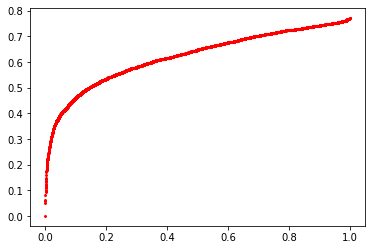

In [ ]:
calculate_ccr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", "logits", OSR_newDatasetAndCIFARLoader)



100%|██████████| 375/375 [00:11<00:00, 31.40it/s]


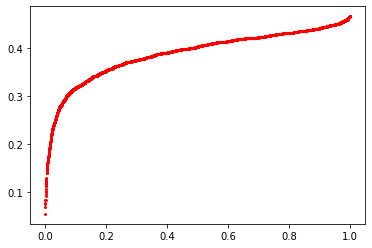

In [ ]:
calculate_ccr("/content/drive/MyDrive/Unknown_Detection/Final_bn_model.pth", "/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", "softmax", OSR_newDatasetAndCIFARLoader)


# Train and Validate with Outlier Exposure: 

In [ ]:
epochs = 20
def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))
    
def train_bn_classifier_OE(net, epochs, folder_weights, train_data_loader, valid_data_loader):

  if os.path.exists(folder_weights): 
    raise RuntimeError("Folder already exists")

  os.mkdir(folder_weights)

  top_paths = {}
  best_model = {}

  lr = 0.001
  net = net.cuda()
  bn_optimizer = torch.optim.SGD(
  net.fc.parameters(), lr, momentum=0.9, 
  weight_decay=0.0005, nesterov=True)

  scheduler = torch.optim.lr_scheduler.LambdaLR(
    bn_optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        epochs * len(train_data_loader),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / lr))
  
  model_path = ""
  for e in range(epochs): 
    correct = 0
    num_of_data = 0
    model_path = os.path.join(folder_weights, "bn_model_epoch{}.pth".format(e))
    net.train()  # enter train mode
    loss_avg = 0.0
    for data, target in tqdm(train_data_loader):
      target = target.unsqueeze(1)
      data, target = data.cuda(), target.cuda()
      
      # forward
      x = net(data)

      # backward
      scheduler.step()
      bn_optimizer.zero_grad()
      loss = nn.BCEWithLogitsLoss()(x, target.float())
      loss.backward()
      bn_optimizer.step()

      # exponential moving average
      loss_avg = loss_avg * 0.8 + float(loss) * 0.2
    
    stacked_pred = list()
    stacked_target = list()
    stacked_outs = list()
    # stacked_confidence

    for data, target in tqdm(valid_data_loader): 
      data, target = data.cuda(), target.cuda()
      net.eval()
      num_of_data += data.size(0)

      #forward
      x = net(data)
      x = torch.sigmoid(x)
      x = x.squeeze(-1)

      pred = torch.round(x)

      stacked_outs.extend(x.tolist())
      stacked_pred.extend(pred.tolist()) # Only 0's and 1's
      stacked_target.extend(target.tolist())
      correct += torch.sum(pred == target)

    f_measure = F_measure(stacked_pred, stacked_target) * 100

    roc_measure = roc(stacked_outs, stacked_target)['auc'] * 100
    pr_measure = pr(stacked_outs, stacked_target)['auc'] * 100

    accuracy = (correct / num_of_data) * 100

    top_paths[model_path] = "{} f_measure, {} roc_measure, {} pr_measure, {} accuracy".format(f_measure, roc_measure, pr_measure, accuracy)
    print(model_path)
    best_model[model_path] = roc_measure
    sorted_best_model = sorted(best_model, key = best_model.get, reverse = True)
    '''Clean all the lower roc models'''
    saved_paths = glob.glob(os.path.join(folder_weights, "*.pth"))
    for pth in saved_paths: 
      if pth not in sorted_best_model[:3]: 
        os.remove(pth)

    for m_pf in sorted_best_model[:3]: 
      if not os.path.isfile(m_pf): 
        torch.save(net.state_dict(), model_path)
    
    assert len(glob.glob(os.path.join(folder_weights, "*.pth"))) <= 3
    print("Best Model saved or kept...")

    print("Epoch: {}".format(e))
    print("Loss Avg: {}".format(loss_avg))
    print("Last Learning Rate: {}".format(scheduler.get_last_lr()))
    print("Accuracy: {}%".format(accuracy))
    print("F measure: {}%".format(f_measure))
    print("ROC measure: {}%".format(roc_measure))
    print("PR measure: {}%".format(pr_measure))

    if (e % 5 == 0) and (e != 0): 
      torch.save(net.state_dict(), model_path)
      print("Model saved...")
    
  with open("bn_model_weightsLOGS.txt", 'a+') as f:
    for k in top_paths.keys():
      final_string = '{} : {}'.format(k, top_paths[k]) 
      print(final_string, file=f)

  return net

In [ ]:
newDatasetAndCIFAR = NewDataset_and_CIFAR(trainset, torch.from_numpy(svhn_OEtrainset.data), torch.from_numpy(svhn_OEtrainset.labels), split, train_transform)
train_newDatasetAndCIFARLoader = torch.utils.data.DataLoader(newDatasetAndCIFAR, batch_size = batch_size, shuffle = True)

trained_bn_net = train_bn_classifier_OE(bn_net, epochs, "first_SVHN", train_data_loader = train_newDatasetAndCIFARLoader, valid_data_loader = test_mixedCIFARLoader)

Len of CIFAR: 30000
Len of Entire Dataset 60000


  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 313/313 [00:05<00:00, 52.74it/s]


first_SVHN/bn_model_epoch0.pth
Best Model saved or kept...
Epoch: 0
Loss Avg: 0.5869971581818731
Last Learning Rate: [0.0009938503261272714]
Accuracy: 52.209999084472656%
F measure: 44.00970048634235%
ROC measure: 43.793010416666675%
PR measure: 59.621931345606036%


100%|██████████| 313/313 [00:05<00:00, 53.14it/s]


first_SVHN/bn_model_epoch1.pth
Best Model saved or kept...
Epoch: 1
Loss Avg: 0.4683455873236497
Last Learning Rate: [0.0009755527298894293]
Accuracy: 53.13999557495117%
F measure: 45.89189463814771%
ROC measure: 45.56193541666667%
PR measure: 60.6261909108443%


100%|██████████| 313/313 [00:05<00:00, 52.75it/s]


first_SVHN/bn_model_epoch2.pth
Best Model saved or kept...
Epoch: 2
Loss Avg: 0.4867886134996742
Last Learning Rate: [0.0009455577588320897]
Accuracy: 54.27000045776367%
F measure: 45.90183062029969%
ROC measure: 46.67087291666667%
PR measure: 61.356802952324266%


100%|██████████| 313/313 [00:05<00:00, 53.66it/s]


first_SVHN/bn_model_epoch3.pth
Best Model saved or kept...
Epoch: 3
Loss Avg: 0.43048991132718584
Last Learning Rate: [0.0009046039886902862]
Accuracy: 53.95000076293945%
F measure: 45.823447190878674%
ROC measure: 48.215014583333335%
PR measure: 62.25753182125631%


100%|██████████| 313/313 [00:05<00:00, 52.89it/s]


first_SVHN/bn_model_epoch4.pth
Best Model saved or kept...
Epoch: 4
Loss Avg: 0.4522657282196503
Last Learning Rate: [0.0008536998372026805]
Accuracy: 53.64999771118164%
F measure: 45.8994307184433%
ROC measure: 47.87713333333333%
PR measure: 62.046986922576345%


100%|██████████| 313/313 [00:05<00:00, 53.02it/s]


first_SVHN/bn_model_epoch5.pth
Best Model saved or kept...
Epoch: 5
Loss Avg: 0.3996168313274956
Last Learning Rate: [0.0007940987335200903]
Accuracy: 54.189998626708984%
F measure: 44.94955818505435%
ROC measure: 47.981064583333335%
PR measure: 62.303791086087436%
Model saved...


100%|██████████| 313/313 [00:05<00:00, 53.92it/s]


first_SVHN/bn_model_epoch6.pth
Best Model saved or kept...
Epoch: 6
Loss Avg: 0.40810125086869814
Last Learning Rate: [0.0007272682546199036]
Accuracy: 53.96000289916992%
F measure: 45.07507893131088%
ROC measure: 47.40307916666667%
PR measure: 62.03491740999032%


100%|██████████| 313/313 [00:05<00:00, 53.74it/s]


first_SVHN/bn_model_epoch7.pth
Best Model saved or kept...
Epoch: 7
Loss Avg: 0.4287593699982892
Last Learning Rate: [0.0006548539886902863]
Accuracy: 54.22999954223633%
F measure: 45.62037851186822%
ROC measure: 48.16992916666666%
PR measure: 62.37273424404912%


100%|██████████| 313/313 [00:06<00:00, 51.89it/s]


first_SVHN/bn_model_epoch8.pth
Best Model saved or kept...
Epoch: 8
Loss Avg: 0.4292762802211331
Last Learning Rate: [0.0005786390152875953]
Accuracy: 54.10000228881836%
F measure: 44.911809928605706%
ROC measure: 47.73502083333334%
PR measure: 62.22791031293138%


100%|██████████| 313/313 [00:05<00:00, 52.73it/s]


first_SVHN/bn_model_epoch9.pth
Best Model saved or kept...
Epoch: 9
Loss Avg: 0.404620993787299
Last Learning Rate: [0.0005005]
Accuracy: 54.35000228881836%
F measure: 45.43008391777235%
ROC measure: 48.180954166666666%
PR measure: 62.48672879556233%


100%|██████████| 313/313 [00:06<00:00, 51.01it/s]


first_SVHN/bn_model_epoch10.pth
Best Model saved or kept...
Epoch: 10
Loss Avg: 0.4360558444969821
Last Learning Rate: [0.0004223609847124046]
Accuracy: 54.439998626708984%
F measure: 45.12535892543986%
ROC measure: 47.90732291666666%
PR measure: 62.221059843545156%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 49.82it/s]


first_SVHN/bn_model_epoch11.pth
Best Model saved or kept...
Epoch: 11
Loss Avg: 0.3848683786716368
Last Learning Rate: [0.0003461460113097138]
Accuracy: 55.349998474121094%
F measure: 44.696759201601544%
ROC measure: 48.32898958333333%
PR measure: 62.47561951309714%


100%|██████████| 313/313 [00:06<00:00, 49.68it/s]


first_SVHN/bn_model_epoch12.pth
Best Model saved or kept...
Epoch: 12
Loss Avg: 0.3944335923437069
Last Learning Rate: [0.00027373174538009644]
Accuracy: 55.18000030517578%
F measure: 45.613636653758746%
ROC measure: 49.68810416666666%
PR measure: 63.33684308533671%


100%|██████████| 313/313 [00:06<00:00, 50.76it/s]


first_SVHN/bn_model_epoch13.pth
Best Model saved or kept...
Epoch: 13
Loss Avg: 0.4017040643429514
Last Learning Rate: [0.00020690126647990973]
Accuracy: 54.529998779296875%
F measure: 45.976810376549004%
ROC measure: 49.56703541666666%
PR measure: 63.29364311210499%


100%|██████████| 313/313 [00:05<00:00, 52.18it/s]


first_SVHN/bn_model_epoch14.pth
Best Model saved or kept...
Epoch: 14
Loss Avg: 0.41073150341057285
Last Learning Rate: [0.00014730016279731955]
Accuracy: 55.029998779296875%
F measure: 45.4260653339923%
ROC measure: 49.35063958333333%
PR measure: 63.27228218055664%


100%|██████████| 313/313 [00:05<00:00, 52.84it/s]


first_SVHN/bn_model_epoch15.pth
Best Model saved or kept...
Epoch: 15
Loss Avg: 0.37444895084034946
Last Learning Rate: [9.63960113097138e-05]
Accuracy: 54.94999694824219%
F measure: 45.92666010704841%
ROC measure: 49.512079166666666%
PR measure: 63.21919163213212%
Model saved...


100%|██████████| 313/313 [00:05<00:00, 52.44it/s]


first_SVHN/bn_model_epoch16.pth
Best Model saved or kept...
Epoch: 16
Loss Avg: 0.3829249227838478
Last Learning Rate: [5.54422411679103e-05]
Accuracy: 55.18000030517578%
F measure: 45.52475269185752%
ROC measure: 49.805729166666666%
PR measure: 63.462211016039745%


100%|██████████| 313/313 [00:05<00:00, 52.99it/s]


first_SVHN/bn_model_epoch17.pth
Best Model saved or kept...
Epoch: 17
Loss Avg: 0.29242573619565054
Last Learning Rate: [2.544727011057081e-05]
Accuracy: 54.959999084472656%
F measure: 45.88020511306134%
ROC measure: 50.348677083333335%
PR measure: 63.674999590316695%


100%|██████████| 313/313 [00:05<00:00, 53.23it/s]


first_SVHN/bn_model_epoch18.pth
Best Model saved or kept...
Epoch: 18
Loss Avg: 0.401879516108563
Last Learning Rate: [7.14967387272874e-06]
Accuracy: 54.77000045776367%
F measure: 45.07696201503021%
ROC measure: 48.75319166666666%
PR measure: 62.853198793083095%


100%|██████████| 313/313 [00:05<00:00, 53.65it/s]

first_SVHN/bn_model_epoch19.pth
Best Model saved or kept...
Epoch: 19
Loss Avg: 0.3870376119062494
Last Learning Rate: [1e-06]
Accuracy: 55.409996032714844%
F measure: 44.902533520889605%
ROC measure: 49.08619375%
PR measure: 63.075209427530865%


In [ ]:
train_MNISTAndCIFAR = NewDataset_and_CIFAR(trainset, mnist_OEtrainset.data, mnist_OEtrainset.targets, split, train_transform)
train_MNISTAndCIFARLoader = torch.utils.data.DataLoader(MNISTAndCIFAR, batch_size = batch_size, shuffle = True)

trained_bn_net = train_bn_classifier_OE(bn_net, epochs, "first_MNIST", train_data_loader = train_MNISTAndCIFARLoader, valid_data_loader = test_mixedCIFARLoader)

Len of CIFAR: 30000
Len of Entire Dataset 60000


  0%|          | 0/375 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 313/313 [00:06<00:00, 51.96it/s]


first_MNIST/bn_model_epoch0.pth
Best Model saved or kept...
Epoch: 0
Loss Avg: 0.6900862940705421
Last Learning Rate: [0.0009938503261272714]
Accuracy: 59.999996185302734%
F measure: 37.49999999999999%
ROC measure: 56.1010375%
PR measure: 66.46410471720876%


100%|██████████| 313/313 [00:06<00:00, 52.01it/s]


first_MNIST/bn_model_epoch1.pth
Best Model saved or kept...
Epoch: 1
Loss Avg: 0.6826887744602441
Last Learning Rate: [0.0009755527298894293]
Accuracy: 58.48999786376953%
F measure: 44.16629593275476%
ROC measure: 57.03785208333334%
PR measure: 67.25250633928438%


100%|██████████| 313/313 [00:07<00:00, 44.35it/s]


first_MNIST/bn_model_epoch2.pth
Best Model saved or kept...
Epoch: 2
Loss Avg: 0.6345701510019444
Last Learning Rate: [0.0009455577588320897]
Accuracy: 58.32999801635742%
F measure: 47.76689434175325%
ROC measure: 57.75363541666667%
PR measure: 68.10993448806772%


100%|██████████| 313/313 [00:06<00:00, 52.15it/s]


first_MNIST/bn_model_epoch3.pth
Best Model saved or kept...
Epoch: 3
Loss Avg: 0.49753312841935743
Last Learning Rate: [0.0009046039886902862]
Accuracy: 59.52999496459961%
F measure: 47.564319902426874%
ROC measure: 57.69566875000001%
PR measure: 67.46139131389572%


100%|██████████| 313/313 [00:05<00:00, 52.29it/s]


first_MNIST/bn_model_epoch4.pth
Best Model saved or kept...
Epoch: 4
Loss Avg: 0.3789077058404059
Last Learning Rate: [0.0008536998372026805]
Accuracy: 60.84000015258789%
F measure: 48.07621859519493%
ROC measure: 58.087772916666665%
PR measure: 67.37158043455197%


100%|██████████| 313/313 [00:06<00:00, 51.72it/s]


first_MNIST/bn_model_epoch5.pth
Best Model saved or kept...
Epoch: 5
Loss Avg: 0.33029587899922414
Last Learning Rate: [0.0007940987335200903]
Accuracy: 61.29999923706055%
F measure: 49.384039068929994%
ROC measure: 58.32293958333333%
PR measure: 66.9950026528527%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 51.59it/s]


first_MNIST/bn_model_epoch6.pth
Best Model saved or kept...
Epoch: 6
Loss Avg: 0.31066187201419315
Last Learning Rate: [0.0007272682546199036]
Accuracy: 62.1199951171875%
F measure: 51.55458869359813%
ROC measure: 60.72355416666666%
PR measure: 68.44801889799443%


100%|██████████| 313/313 [00:05<00:00, 52.72it/s]


first_MNIST/bn_model_epoch7.pth
Best Model saved or kept...
Epoch: 7
Loss Avg: 0.24131094779795967
Last Learning Rate: [0.0006548539886902863]
Accuracy: 62.44999694824219%
F measure: 51.820796045933385%
ROC measure: 62.13020625%
PR measure: 69.2271116489788%


100%|██████████| 313/313 [00:06<00:00, 51.70it/s]


first_MNIST/bn_model_epoch8.pth
Best Model saved or kept...
Epoch: 8
Loss Avg: 0.24992044880086675
Last Learning Rate: [0.0005786390152875953]
Accuracy: 61.969993591308594%
F measure: 49.23235733307895%
ROC measure: 61.631499999999996%
PR measure: 68.74865385446924%


100%|██████████| 313/313 [00:05<00:00, 52.50it/s]


first_MNIST/bn_model_epoch9.pth
Best Model saved or kept...
Epoch: 9
Loss Avg: 0.22383538070687892
Last Learning Rate: [0.0005005]
Accuracy: 62.44999694824219%
F measure: 52.54298749084968%
ROC measure: 62.24036041666666%
PR measure: 69.2005090696411%


100%|██████████| 313/313 [00:06<00:00, 51.63it/s]


first_MNIST/bn_model_epoch10.pth
Best Model saved or kept...
Epoch: 10
Loss Avg: 0.3460740553220203
Last Learning Rate: [0.0004223609847124046]
Accuracy: 62.50999450683594%
F measure: 51.616426281353256%
ROC measure: 62.36202500000001%
PR measure: 69.17096561199362%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 51.16it/s]


first_MNIST/bn_model_epoch11.pth
Best Model saved or kept...
Epoch: 11
Loss Avg: 0.1937125299016545
Last Learning Rate: [0.0003461460113097138]
Accuracy: 62.91999816894531%
F measure: 52.463915265775164%
ROC measure: 63.0800625%
PR measure: 69.41904305356641%


100%|██████████| 313/313 [00:06<00:00, 52.06it/s]


first_MNIST/bn_model_epoch12.pth
Best Model saved or kept...
Epoch: 12
Loss Avg: 0.22237378453894752
Last Learning Rate: [0.00027373174538009644]
Accuracy: 62.29999542236328%
F measure: 50.81653424442507%
ROC measure: 62.24475833333334%
PR measure: 68.896512090867%


100%|██████████| 313/313 [00:05<00:00, 52.46it/s]


first_MNIST/bn_model_epoch13.pth
Best Model saved or kept...
Epoch: 13
Loss Avg: 0.27254469604738313
Last Learning Rate: [0.00020690126647990973]
Accuracy: 62.93999481201172%
F measure: 52.60330139875254%
ROC measure: 63.48281874999999%
PR measure: 69.99520807749609%


100%|██████████| 313/313 [00:05<00:00, 52.25it/s]


first_MNIST/bn_model_epoch14.pth
Best Model saved or kept...
Epoch: 14
Loss Avg: 0.2579931389357083
Last Learning Rate: [0.00014730016279731955]
Accuracy: 62.209999084472656%
F measure: 50.5176587470173%
ROC measure: 62.140366666666665%
PR measure: 68.82881803092961%


100%|██████████| 313/313 [00:05<00:00, 52.35it/s]


first_MNIST/bn_model_epoch15.pth
Best Model saved or kept...
Epoch: 15
Loss Avg: 0.265302052384042
Last Learning Rate: [9.63960113097138e-05]
Accuracy: 62.68999481201172%
F measure: 51.50211570232936%
ROC measure: 62.62562291666667%
PR measure: 69.02727233582698%
Model saved...


100%|██████████| 313/313 [00:06<00:00, 51.73it/s]


first_MNIST/bn_model_epoch16.pth
Best Model saved or kept...
Epoch: 16
Loss Avg: 0.28297247932055525
Last Learning Rate: [5.54422411679103e-05]
Accuracy: 62.83000183105469%
F measure: 52.75999506426464%
ROC measure: 63.3228375%
PR measure: 69.9709807625361%


100%|██████████| 313/313 [00:05<00:00, 52.37it/s]


first_MNIST/bn_model_epoch17.pth
Best Model saved or kept...
Epoch: 17
Loss Avg: 0.23571962698333393
Last Learning Rate: [2.544727011057081e-05]
Accuracy: 62.709999084472656%
F measure: 52.015230975631496%
ROC measure: 63.0104125%
PR measure: 69.40773472848318%


100%|██████████| 313/313 [00:05<00:00, 52.88it/s]


first_MNIST/bn_model_epoch18.pth
Best Model saved or kept...
Epoch: 18
Loss Avg: 0.18060951389322633
Last Learning Rate: [7.14967387272874e-06]
Accuracy: 62.68999481201172%
F measure: 52.012806805656666%
ROC measure: 63.46702291666666%
PR measure: 70.08392986323022%


100%|██████████| 313/313 [00:05<00:00, 52.56it/s]

first_MNIST/bn_model_epoch19.pth
Best Model saved or kept...
Epoch: 19
Loss Avg: 0.23308558808445362
Last Learning Rate: [1e-06]
Accuracy: 62.18000030517578%
F measure: 50.294330636014394%
ROC measure: 62.025962500000006%
PR measure: 68.87436081100905%


SVHN vs CIFAR closed Set trained model validated on CIFAR open vs closed set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/REAL_SVHN_CIFAR_bn_model_epoch12.pth", test_mixedCIFARLoader)

100%|██████████| 313/313 [00:07<00:00, 40.78it/s]



ROC AU value: 49.6880875%
PR AU value: 63.33667461012355%
F Measure: 45.613636653758746% - Predictions through rounding


SVHN vs CIFAR closed Set trained model validated on Uniform Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/REAL_SVHN_CIFAR_bn_model_epoch12.pth", uniformDisLoader)


100%|██████████| 7/7 [00:00<00:00, 44.90it/s]



ROC AU value: 95.83%
PR AU value: 97.59959860111134%
F Measure: 86.24939522803086% - Predictions through rounding


SVHN vs CIFAR closed Set trained model validated on Normal Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/REAL_SVHN_CIFAR_bn_model_epoch12.pth", normalDisLoader)


100%|██████████| 7/7 [00:00<00:00, 44.42it/s]



ROC AU value: 50.970000000000006%
PR AU value: 66.2853694756702%
F Measure: 30.1909815829053% - Predictions through rounding


SVHN vs CIFAR closed Set trained model validated on Test SVHN + CIFAR Closed Test set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/REAL_SVHN_CIFAR_bn_model_epoch12.pth", newDatasetAndCIFARLoader)


100%|██████████| 375/375 [00:08<00:00, 45.69it/s]



ROC AU value: 91.70215694444444%
PR AU value: 92.82544768090413%
F Measure: 83.90233930148774% - Predictions through rounding


SVHN vs CIFAR closed Set trained model validated on Heavy Transfomed CIFAR Closed Set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/REAL_SVHN_CIFAR_bn_model_epoch12.pth", closed_set_heavy_TransformsLoader)


100%|██████████| 188/188 [00:23<00:00,  8.03it/s]




ROC AU value: 64.69968333333334%
PR AU value: 64.980907179648%
F Measure: 56.68280137961368% - Predictions through rounding


MNIST vs CIFAR closed Set trained model validated on CIFAR open vs closed set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/MNIST_CIFAR_bn_model_epoch18.pth", test_mixedCIFARLoader)


100%|██████████| 313/313 [00:06<00:00, 46.66it/s]




ROC AU value: 63.46702083333333%
PR AU value: 70.08215364442061%
F Measure: 52.012806805656666% - Predictions through rounding


MNIST vs CIFAR closed Set trained model validated on Uniform Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/MNIST_CIFAR_bn_model_epoch18.pth", uniformDisLoader)


100%|██████████| 7/7 [00:00<00:00, 47.63it/s]



ROC AU value: 56.7%
PR AU value: 72.50942057323935%
F Measure: 31.27147766323024% - Predictions through rounding


MNIST vs CIFAR closed Set trained model validated on Normal Noise Loader

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/MNIST_CIFAR_bn_model_epoch18.pth", normalDisLoader)


100%|██████████| 7/7 [00:00<00:00, 46.34it/s]



ROC AU value: 80.78%
PR AU value: 83.78216383272495%
F Measure: 61.81871958269474% - Predictions through rounding


MNIST vs CIFAR closed Set trained model validated on Test SVHN + CIFAR Closed Test set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/MNIST_CIFAR_bn_model_epoch18.pth", newDatasetAndCIFARLoader)


100%|██████████| 375/375 [00:07<00:00, 51.55it/s]



ROC AU value: 53.88314861111111%
PR AU value: 61.1419029606878%
F Measure: 34.89280918058944% - Predictions through rounding


MNIST vs CIFAR closed Set trained model validated on Heavy Transfomed CIFAR Closed Set

In [ ]:
roc_pr_bn_metrics = evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/MNIST_CIFAR_bn_model_epoch18.pth", closed_set_heavy_TransformsLoader)


100%|██████████| 188/188 [00:24<00:00,  7.58it/s]



ROC AU value: 38.20793888888889%
PR AU value: 41.96198468219004%
F Measure: 36.577724605636% - Predictions through rounding
